In [123]:
'''
Hyperparameter Tuning

NEW VERSION

includes more parameters and biases

Sources:
(1) https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search
'''
import argparse
import numpy as np
import networkx as nx
import time
import torch
import torch.nn.functional as F
from dgl import DGLGraph
from dgl.data import register_data_args, load_data
from gat import GAT
from utils2 import EarlyStopping

import numpy as np
import tensorflow as tf
import argparse
import networkx as nx
from dgl import DGLGraph


import sys
import pandas as pd

### ADDED

sys.argv = ['foo']
parser = argparse.ArgumentParser(description='GAT')
#     register_data_args(parser) #to avoid conflict with check for standard data sources
parser.add_argument("--gpu", type=int, default=-1,
                    help="which GPU to use. Set -1 to use CPU.")
parser.add_argument("--epochs", type=int, default=20,
                    help="number of training epochs")
parser.add_argument("--num-heads", type=int, default=12, #was 8
                    help="number of hidden attention heads")
parser.add_argument("--num-out-heads", type=int, default=1,
                    help="number of output attention heads")
parser.add_argument("--num-layers", type=int, default=1,
                    help="number of hidden layers")
parser.add_argument("--num-hidden", type=int, default=10, #was 8
                    help="number of hidden units")
parser.add_argument("--residual", action="store_true", default=False,
                    help="use residual connection")
parser.add_argument("--in-drop", type=float, default=.6, #was .6
                    help="input feature dropout")
parser.add_argument("--attn-drop", type=float, default=.6,
                    help="attention dropout")
parser.add_argument("--lr", type=float, default=0.001, #was 0.005
                    help="learning rate")
parser.add_argument('--weight-decay', type=float, default=5e-4,
                    help="weight decay")
parser.add_argument('--negative-slope', type=float, default=0.2,
                    help="the negative slope of leaky relu")
parser.add_argument('--fastmode', action="store_true", default=False,
                    help="skip re-evaluate the validation set")
args = parser.parse_args()
print(args)
###


sys.path.insert(1, '../../../../Fake-News-Detection/codebase/')
# from models import GAT
# from utils import process
from gat_adj_features import GATInputGenerator 
from utils import process

MAX_EVALS = 90
epochs = 10
# embed_dim = 5
num_classes = 2

param_grid = {
    'num_heads': [4,8,12], #[8,12]
    'num_layers': [1], 
    'num_hidden': [8,10,20], #[10, 20, 50]
    'in_drop': [0.6,0.8],#[0.6,0.8]
    'attn_drop': [0.6,0.8],
    'lr':[0.01, 0.001, 0.0001],
    'negative_slope':[0.2,0.1,0.0]
}

# Dataframes for random and grid search
# random_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
#                               index = list(range(MAX_EVALS)))

# grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
#                               index = list(range(MAX_EVALS)))


def accuracy(logits, labels):
    _, indices = torch.max(logits, dim=1)
    correct = torch.sum(indices == labels)
    return correct.item() * 1.0 / len(labels)

def evaluate(model, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features)
        logits = logits[mask]
        labels = labels[mask]
        return accuracy(logits, labels)

# def precision(logits, labels):
#     _, indices = torch.max(logits, dim=1)
#     tp = torch.sum(indices[indices==1] == labels[labels==1])
#     fp = torch.sum(indices[indices==1] != labels[labels==1])
#     return tp/(tp+fp)
    

# def evaluate(model, features, labels, mask):
#     model.eval()
#     with torch.no_grad():
#         logits = model(features)
#         logits = logits[mask]
#         labels = labels[mask]
#         return accuracy(logits, labels), precision(logits, labels)

sys.path.insert(1, '../../../../Fake-News-Detection/codebase/')
dataset = 'BuzzFeed'
checkpt_file = '../../../../Fake-News-Detection/pre_trained/BuzzFeed/mod_BuzzFeed.ckpt'
gat_ip = GATInputGenerator()
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, labels, all_data_df = gat_ip.getComps(dataset=dataset)

features, spars = process.preprocess_features(features)

adj_dense = adj.todense() #is this needed?

Mc = adj.tocoo()
A = np.column_stack((Mc.row, Mc.col, Mc.data))
b = A[A[:,2]!=0]
c = np.delete(b,2,1)
d = np.column_stack((c[:,0], c[:,1]))

edge_list = tuple(map(tuple, d))
graph = nx.DiGraph(nx.from_edgelist(edge_list))


#     data = load_data(args)
features = torch.FloatTensor(features)
#     features = torch.FloatTensor(data.features)    
labels = torch.LongTensor(labels)
#     labels = torch.LongTensor(data.labels)
if hasattr(torch, 'BoolTensor'):
    train_mask = torch.BoolTensor(train_mask)
    val_mask = torch.BoolTensor(val_mask)
    test_mask = torch.BoolTensor(test_mask)
else:
    train_mask = torch.ByteTensor(train_mask)
    val_mask = torch.ByteTensor(val_mask)
    test_mask = torch.ByteTensor(test_mask)
#     if hasattr(torch, 'BoolTensor'):
#         train_mask = torch.BoolTensor(data.train_mask)
#         val_mask = torch.BoolTensor(data.val_mask)
#         test_mask = torch.BoolTensor(data.test_mask)
#     else:
#         train_mask = torch.ByteTensor(data.train_mask)
#         val_mask = torch.ByteTensor(data.val_mask)
#         test_mask = torch.ByteTensor(data.test_mask)
num_feats = features.shape[1]
#     n_classes = data.num_labels
n_classes = 2 # hard coded as true or false for fake news
#     n_edges = data.graph.number_of_edges()
n_edges = graph.number_of_edges()  #not sure if the number_of_edges() function will work here
print("""----Data statistics------'
  #Edges %d
  #Classes %d 
  #Train samples %d
  #Val samples %d
  #Test samples %d""" %
      (n_edges, n_classes,
       train_mask.int().sum().item(),
       val_mask.int().sum().item(),
       test_mask.int().sum().item()))

if args.gpu < 0:
    cuda = False
else:
    cuda = True
    torch.cuda.set_device(args.gpu)
    features = features.cuda()
    labels = labels.cuda()
    train_mask = train_mask.cuda()
    val_mask = val_mask.cuda()
    test_mask = test_mask.cuda()

#     graph.remove_edges_from(nx.selfloop_edges(graph))
#     g = data.graph
g = graph
# add self loop
g.remove_edges_from(nx.selfloop_edges(g))
g = DGLGraph(g)
g.add_edges(g.nodes(), g.nodes())
n_edges = g.number_of_edges()    
    
    
#Added 
nb_nodes = adj.shape[0] # = features.shape[0]
adj = adj.todense()
adj = adj[np.newaxis]

import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh

def adj_to_bias(adj, sizes, nhood=1):
    nb_graphs = adj.shape[0]
    mt = np.empty(adj.shape)
    for g in range(nb_graphs):
        mt[g] = np.eye(adj.shape[1])
        for _ in range(nhood):
            mt[g] = np.matmul(mt[g], (adj[g] + np.eye(adj.shape[1])))
        for i in range(sizes[g]):
            for j in range(sizes[g]):
                if mt[g][i][j] > 0.0:
                    mt[g][i][j] = 1.0
    return -1e9 * (1.0 - mt)
########

biases = process.adj_to_bias(adj, [nb_nodes], nhood=1)

def train(hyperparameters, iteration):
    
    num_heads = hyperparameters.get('num_heads')
    num_layers = hyperparameters.get('num_layers')
    num_hidden = hyperparameters.get('num_hidden')
    in_drop = hyperparameters.get('in_drop')
    attn_drop = hyperparameters.get('attn_drop')
    lr = hyperparameters.get('lr')
    negative_slope = hyperparameters.get('negative_slope')
    
    print('num_heads: ', num_heads, 'num_layers: ', num_layers, 'num_hidden: ', num_hidden,
          'in_drop', in_drop, 'atten_drop', attn_drop, 'lr', lr, 'negative_slope', negative_slope)

    # create model
    heads = ([args.num_heads] * args.num_layers) + [args.num_out_heads]
    model = GAT(g,
                num_layers,
                num_feats,
                num_hidden,
                n_classes,
                heads,
                F.elu,
                in_drop,
                attn_drop,
                args.negative_slope,
                args.residual)
    print(model)
    stopper = EarlyStopping(patience=100)
    if cuda:
        model.cuda()
    loss_fcn = torch.nn.CrossEntropyLoss()

    # use optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

    # initialize graph
    dur = []
    for epoch in range(args.epochs):
        model.train()
        if epoch >= 3:
            t0 = time.time()
        # forward
        logits = model(features)
        loss = loss_fcn(logits[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch >= 3:
            dur.append(time.time() - t0)

        train_acc = accuracy(logits[train_mask], labels[train_mask])

        if args.fastmode:
            val_acc = accuracy(logits[val_mask], labels[val_mask])
        else:
            val_acc = evaluate(model, features, labels, val_mask)
            if stopper.step(val_acc, model):   
                break

        print("Epoch {:05d} | Time(s) {:.4f} | Loss {:.4f} | TrainAcc {:.4f} |"
              " ValAcc {:.4f} | ETputs(KTEPS) {:.2f}".
              format(epoch, np.mean(dur), loss.item(), train_acc,
                     val_acc, n_edges / np.mean(dur) / 1000))

    print()
    model.load_state_dict(torch.load('es_checkpoint.pt'))
    acc = evaluate(model, features, labels, test_mask)
#     acc, prec = evaluate(model, features, labels, test_mask)
    print("Test Accuracy {:.4f}".format(acc))
    
    return [loss, acc, iteration, num_heads, num_layers, num_hidden, in_drop, attn_drop, lr, negative_slope]
#     return [loss, acc, prec, iteration, num_heads, num_layers, num_hidden, in_drop, attn_drop, lr, negative_slope]

#     return g, model, logits, 
    
#     num_filters = hyperparameters.get("num_filters")
#     kernel_sizes = hyperparameters.get("kernel_sizes")
#     dense_layer_dims = hyperparameters.get("dense_layer_dims")
#     dropout_rate = hyperparameters.get("dropout_rate")[0]
    
#     print(num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

#     wordids = keras.layers.Input(shape=(max_len,))

#     h = keras.layers.Embedding(ds.vocab.size, embed_dim, input_length=max_len)(wordids)

#     conv_layers_for_all_kernel_sizes = []
#     for filters, kernel_size in zip(kernel_sizes, num_filters):
#         conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h)
#         conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
#         conv_layers_for_all_kernel_sizes.append(conv_layer)

#     h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

#     h = keras.layers.Dropout(rate=dropout_rate)(h)


#     for dense_layer_dim in dense_layer_dims:
# #         h = keras.layers.Dense(dense_layer_dim, activation='relu', name='Dense_Layer' + str(dense_layer_dim))(h)
#         h = keras.layers.Dense(dense_layer_dim, activation='relu')(h)
#     prediction = keras.layers.Dense(num_classes, activation='softmax')(h)

#     model = keras.Model(inputs=wordids, outputs=prediction)
#     model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',  # From information theory notebooks.
#                   metrics=['accuracy'])        # What metric to output as we train.
#     model.reset_states()
#     model.fit(train_x, train_y, epochs=epochs, verbose=0)
#     loss, acc = model.evaluate(x=dev_x, y=dev_y, verbose=1, workers=1, use_multiprocessing=True)
# #     print(num_filters, kernel_sizes, dense_layer_dims, dropout_rate)
#     return [loss,acc,iteration, num_filters, kernel_sizes, dense_layer_dims, dropout_rate]

import itertools
import random

random.seed(42)

def grid_search(param_grid, max_evals = 5):
    """Grid search algorithm (with limit on max evals)"""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['loss', 'acc', 'iteration', 'num_heads', 'num_layers', 'num_hidden', 'in_drop', 
                                      'attn_drop', 'lr', 'negative_slope'],
                              index = list(range(MAX_EVALS)))
#     results = pd.DataFrame(columns = ['loss', 'acc', 'prec', 'iteration', 'num_heads', 'num_layers', 'num_hidden', 'in_drop', 
#                                       'attn_drop', 'lr', 'negative_slope'],
#                               index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
#     print(values)
    for v in itertools.product(*values):
        
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))
#         print(hyperparameters)
        # Evalute the hyperparameters
        eval_results = train(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('acc', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results  

def random_search(param_grid, MAX_EVALS = 5):
    """Random search for hyperparameter optimization"""
    acc_mx = 0.0
 

    # Dataframe for results
    results = pd.DataFrame(columns = ['loss', 'acc', 'iteration', 'num_heads', 'num_layers', 'num_hidden', 'in_drop', 
                                      'attn_drop', 'lr', 'negative_slope'],
                              index = list(range(MAX_EVALS)))
#     results = pd.DataFrame(columns = ['loss', 'acc', 'prec', 'iteration', 'num_heads', 'num_layers', 'num_hidden', 'in_drop', 
#                                       'attn_drop', 'lr', 'negative_slope'],
#                               index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for i in range(MAX_EVALS):
        
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}

        # Evaluate randomly selected hyperparameters
        eval_results = train(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        if eval_results[1] > 0.66:
            pass

    

    # Sort with best score on top
    results.sort_values('acc', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results

Namespace(attn_drop=0.6, epochs=20, fastmode=False, gpu=-1, in_drop=0.6, lr=0.001, negative_slope=0.2, num_heads=12, num_hidden=10, num_layers=1, num_out_heads=1, residual=False, weight_decay=0.0005)
BuzzFeed
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 5 . 2 ##k shares facebook twitter president obama has always been a far left border ##line socialist progressive liberal . their is no denying that . why else would he push such ridiculous police ##s such as the affordable care act , gun control , and an ever increasing acceptance number of refugees . well apparently he has not changed his tune . because president obama appeared at his final united nations general assembly meeting to give his final speech as a sitting president . while there he said some absolutely ridiculous things about american freedom that will have most americans absolutely fl ##ab ##berg ##ast ##ed at . during his speech he effectively advocated for a one world order style of international governance and [SEP]


INFO:tensorflow:tokens: [CLS] 5 . 2 ##k shares facebook twitter president obama has always been a far left border ##line socialist progressive liberal . their is no denying that . why else would he push such ridiculous police ##s such as the affordable care act , gun control , and an ever increasing acceptance number of refugees . well apparently he has not changed his tune . because president obama appeared at his final united nations general assembly meeting to give his final speech as a sitting president . while there he said some absolutely ridiculous things about american freedom that will have most americans absolutely fl ##ab ##berg ##ast ##ed at . during his speech he effectively advocated for a one world order style of international governance and [SEP]


INFO:tensorflow:input_ids: 101 1019 1012 1016 2243 6661 9130 10474 2343 8112 2038 2467 2042 1037 2521 2187 3675 4179 6102 6555 4314 1012 2037 2003 2053 16039 2008 1012 2339 2842 2052 2002 5245 2107 9951 2610 2015 2107 2004 1996 15184 2729 2552 1010 3282 2491 1010 1998 2019 2412 4852 9920 2193 1997 8711 1012 2092 4593 2002 2038 2025 2904 2010 8694 1012 2138 2343 8112 2596 2012 2010 2345 2142 3741 2236 3320 3116 2000 2507 2010 2345 4613 2004 1037 3564 2343 1012 2096 2045 2002 2056 2070 7078 9951 2477 2055 2137 4071 2008 2097 2031 2087 4841 7078 13109 7875 4059 14083 2098 2012 1012 2076 2010 4613 2002 6464 11886 2005 1037 2028 2088 2344 2806 1997 2248 10615 1998 102


INFO:tensorflow:input_ids: 101 1019 1012 1016 2243 6661 9130 10474 2343 8112 2038 2467 2042 1037 2521 2187 3675 4179 6102 6555 4314 1012 2037 2003 2053 16039 2008 1012 2339 2842 2052 2002 5245 2107 9951 2610 2015 2107 2004 1996 15184 2729 2552 1010 3282 2491 1010 1998 2019 2412 4852 9920 2193 1997 8711 1012 2092 4593 2002 2038 2025 2904 2010 8694 1012 2138 2343 8112 2596 2012 2010 2345 2142 3741 2236 3320 3116 2000 2507 2010 2345 4613 2004 1037 3564 2343 1012 2096 2045 2002 2056 2070 7078 9951 2477 2055 2137 4071 2008 2097 2031 2087 4841 7078 13109 7875 4059 14083 2098 2012 1012 2076 2010 4613 2002 6464 11886 2005 1037 2028 2088 2344 2806 1997 2248 10615 1998 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 2 . 8 ##k shares facebook twitter a border wall isn ’ t just to keep out illegal immigrants – it acts as a national security measure . china didn ’ t build their great wall to keep out immigrants , they built it to keep out foreign invaders . we need a border for that reason too , in addition to solving the problem of illegal immigration . the entire nation of mexico is essentially run by drug cartel ##s , and they ’ ve rack ##ed up a death toll that would make isis en ##vious . additionally , if isis is going to enter america , our un ##se ##cured southern border is their best bet . and for that reason , you [SEP]


INFO:tensorflow:tokens: [CLS] 2 . 8 ##k shares facebook twitter a border wall isn ’ t just to keep out illegal immigrants – it acts as a national security measure . china didn ’ t build their great wall to keep out immigrants , they built it to keep out foreign invaders . we need a border for that reason too , in addition to solving the problem of illegal immigration . the entire nation of mexico is essentially run by drug cartel ##s , and they ’ ve rack ##ed up a death toll that would make isis en ##vious . additionally , if isis is going to enter america , our un ##se ##cured southern border is their best bet . and for that reason , you [SEP]


INFO:tensorflow:input_ids: 101 1016 1012 1022 2243 6661 9130 10474 1037 3675 2813 3475 1521 1056 2074 2000 2562 2041 6206 7489 1516 2009 4490 2004 1037 2120 3036 5468 1012 2859 2134 1521 1056 3857 2037 2307 2813 2000 2562 2041 7489 1010 2027 2328 2009 2000 2562 2041 3097 17347 1012 2057 2342 1037 3675 2005 2008 3114 2205 1010 1999 2804 2000 13729 1996 3291 1997 6206 7521 1012 1996 2972 3842 1997 3290 2003 7687 2448 2011 4319 21680 2015 1010 1998 2027 1521 2310 14513 2098 2039 1037 2331 9565 2008 2052 2191 18301 4372 24918 1012 5678 1010 2065 18301 2003 2183 2000 4607 2637 1010 2256 4895 3366 19405 2670 3675 2003 2037 2190 6655 1012 1998 2005 2008 3114 1010 2017 102


INFO:tensorflow:input_ids: 101 1016 1012 1022 2243 6661 9130 10474 1037 3675 2813 3475 1521 1056 2074 2000 2562 2041 6206 7489 1516 2009 4490 2004 1037 2120 3036 5468 1012 2859 2134 1521 1056 3857 2037 2307 2813 2000 2562 2041 7489 1010 2027 2328 2009 2000 2562 2041 3097 17347 1012 2057 2342 1037 3675 2005 2008 3114 2205 1010 1999 2804 2000 13729 1996 3291 1997 6206 7521 1012 1996 2972 3842 1997 3290 2003 7687 2448 2011 4319 21680 2015 1010 1998 2027 1521 2310 14513 2098 2039 1037 2331 9565 2008 2052 2191 18301 4372 24918 1012 5678 1010 2065 18301 2003 2183 2000 4607 2637 1010 2256 4895 3366 19405 2670 3675 2003 2037 2190 6655 1012 1998 2005 2008 3114 1010 2017 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hillary clinton ’ s health is the top issue in the presidential campaign . once considered a “ conspiracy theory , ” americans now see that hillary clinton suffers from serious problems , including neurological diseases . after her september 11th collapse and faint ##ing , even the pro - hillary media can ’ t hide the truth . now , expert cl ##if hit ##e ( below ) comes up with the most compelling theory about hillary clinton ’ s health yet , and you haven ’ t heard it before . he believes hillary has died , and is replaced by multiple body doubles and c ##gi images . if true , this is the biggest cover ##up in the history of american politics [SEP]


INFO:tensorflow:tokens: [CLS] hillary clinton ’ s health is the top issue in the presidential campaign . once considered a “ conspiracy theory , ” americans now see that hillary clinton suffers from serious problems , including neurological diseases . after her september 11th collapse and faint ##ing , even the pro - hillary media can ’ t hide the truth . now , expert cl ##if hit ##e ( below ) comes up with the most compelling theory about hillary clinton ’ s health yet , and you haven ’ t heard it before . he believes hillary has died , and is replaced by multiple body doubles and c ##gi images . if true , this is the biggest cover ##up in the history of american politics [SEP]


INFO:tensorflow:input_ids: 101 18520 7207 1521 1055 2740 2003 1996 2327 3277 1999 1996 4883 3049 1012 2320 2641 1037 1523 9714 3399 1010 1524 4841 2085 2156 2008 18520 7207 17567 2013 3809 3471 1010 2164 23130 7870 1012 2044 2014 2244 6252 7859 1998 8143 2075 1010 2130 1996 4013 1011 18520 2865 2064 1521 1056 5342 1996 3606 1012 2085 1010 6739 18856 10128 2718 2063 1006 2917 1007 3310 2039 2007 1996 2087 17075 3399 2055 18520 7207 1521 1055 2740 2664 1010 1998 2017 4033 1521 1056 2657 2009 2077 1012 2002 7164 18520 2038 2351 1010 1998 2003 2999 2011 3674 2303 7695 1998 1039 5856 4871 1012 2065 2995 1010 2023 2003 1996 5221 3104 6279 1999 1996 2381 1997 2137 4331 102


INFO:tensorflow:input_ids: 101 18520 7207 1521 1055 2740 2003 1996 2327 3277 1999 1996 4883 3049 1012 2320 2641 1037 1523 9714 3399 1010 1524 4841 2085 2156 2008 18520 7207 17567 2013 3809 3471 1010 2164 23130 7870 1012 2044 2014 2244 6252 7859 1998 8143 2075 1010 2130 1996 4013 1011 18520 2865 2064 1521 1056 5342 1996 3606 1012 2085 1010 6739 18856 10128 2718 2063 1006 2917 1007 3310 2039 2007 1996 2087 17075 3399 2055 18520 7207 1521 1055 2740 2664 1010 1998 2017 4033 1521 1056 2657 2009 2077 1012 2002 7164 18520 2038 2351 1010 1998 2003 2999 2011 3674 2303 7695 1998 1039 5856 4871 1012 2065 2995 1010 2023 2003 1996 5221 3104 6279 1999 1996 2381 1997 2137 4331 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] exposed : so ##ros funding fake veterans ’ pac to take trump down a couple months ago , discover the networks revealed a list of 187 groups who were funded by so ##ros . they have naturally been attacking the presidential candidate who is generally against their values like open borders , amnesty , giving illegal ##s voting rights , muslim migration and social justice . so , why then is so ##ros caught again ? now a new organization is going after trump and sure enough , they ’ re funded by so ##ros too ! it ’ s called ‘ common defense pac ’ and their mantra is : “ as veterans , we swore to protect the rights of every american . we [SEP]


INFO:tensorflow:tokens: [CLS] exposed : so ##ros funding fake veterans ’ pac to take trump down a couple months ago , discover the networks revealed a list of 187 groups who were funded by so ##ros . they have naturally been attacking the presidential candidate who is generally against their values like open borders , amnesty , giving illegal ##s voting rights , muslim migration and social justice . so , why then is so ##ros caught again ? now a new organization is going after trump and sure enough , they ’ re funded by so ##ros too ! it ’ s called ‘ common defense pac ’ and their mantra is : “ as veterans , we swore to protect the rights of every american . we [SEP]


INFO:tensorflow:input_ids: 101 6086 1024 2061 7352 4804 8275 8244 1521 14397 2000 2202 8398 2091 1037 3232 2706 3283 1010 7523 1996 6125 3936 1037 2862 1997 19446 2967 2040 2020 6787 2011 2061 7352 1012 2027 2031 8100 2042 7866 1996 4883 4018 2040 2003 3227 2114 2037 5300 2066 2330 6645 1010 16154 1010 3228 6206 2015 6830 2916 1010 5152 9230 1998 2591 3425 1012 2061 1010 2339 2059 2003 2061 7352 3236 2153 1029 2085 1037 2047 3029 2003 2183 2044 8398 1998 2469 2438 1010 2027 1521 2128 6787 2011 2061 7352 2205 999 2009 1521 1055 2170 1520 2691 3639 14397 1521 1998 2037 25951 2003 1024 1523 2004 8244 1010 2057 12860 2000 4047 1996 2916 1997 2296 2137 1012 2057 102


INFO:tensorflow:input_ids: 101 6086 1024 2061 7352 4804 8275 8244 1521 14397 2000 2202 8398 2091 1037 3232 2706 3283 1010 7523 1996 6125 3936 1037 2862 1997 19446 2967 2040 2020 6787 2011 2061 7352 1012 2027 2031 8100 2042 7866 1996 4883 4018 2040 2003 3227 2114 2037 5300 2066 2330 6645 1010 16154 1010 3228 6206 2015 6830 2916 1010 5152 9230 1998 2591 3425 1012 2061 1010 2339 2059 2003 2061 7352 3236 2153 1029 2085 1037 2047 3029 2003 2183 2044 8398 1998 2469 2438 1010 2027 1521 2128 6787 2011 2061 7352 2205 999 2009 1521 1055 2170 1520 2691 3639 14397 1521 1998 2037 25951 2003 1024 1523 2004 8244 1010 2057 12860 2000 4047 1996 2916 1997 2296 2137 1012 2057 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hillary ’ s top donor country just auction ##ed off isis sex slaves … why in the hell do we still support saudi arabia ? we don ’ t need their oil … we would make do . the majority of the 9 / 11 terrorists came from saudi arabia , as does the bin laden family . the saudi deputy crown prince told reporters in june the kingdom of saudi arabia has funded 20 % of hillary clinton ’ s campaign . she ’ s taking money from a stone cold enemy and that ’ s not the only one by any means . you do not consort or take money from those who intend to destroy your country … period . that goes for [SEP]


INFO:tensorflow:tokens: [CLS] hillary ’ s top donor country just auction ##ed off isis sex slaves … why in the hell do we still support saudi arabia ? we don ’ t need their oil … we would make do . the majority of the 9 / 11 terrorists came from saudi arabia , as does the bin laden family . the saudi deputy crown prince told reporters in june the kingdom of saudi arabia has funded 20 % of hillary clinton ’ s campaign . she ’ s taking money from a stone cold enemy and that ’ s not the only one by any means . you do not consort or take money from those who intend to destroy your country … period . that goes for [SEP]


INFO:tensorflow:input_ids: 101 18520 1521 1055 2327 15009 2406 2074 10470 2098 2125 18301 3348 7179 1529 2339 1999 1996 3109 2079 2057 2145 2490 8174 9264 1029 2057 2123 1521 1056 2342 2037 3514 1529 2057 2052 2191 2079 1012 1996 3484 1997 1996 1023 1013 2340 15554 2234 2013 8174 9264 1010 2004 2515 1996 8026 14887 2155 1012 1996 8174 4112 4410 3159 2409 12060 1999 2238 1996 2983 1997 8174 9264 2038 6787 2322 1003 1997 18520 7207 1521 1055 3049 1012 2016 1521 1055 2635 2769 2013 1037 2962 3147 4099 1998 2008 1521 1055 2025 1996 2069 2028 2011 2151 2965 1012 2017 2079 2025 13440 2030 2202 2769 2013 2216 2040 13566 2000 6033 2115 2406 1529 2558 1012 2008 3632 2005 102


INFO:tensorflow:input_ids: 101 18520 1521 1055 2327 15009 2406 2074 10470 2098 2125 18301 3348 7179 1529 2339 1999 1996 3109 2079 2057 2145 2490 8174 9264 1029 2057 2123 1521 1056 2342 2037 3514 1529 2057 2052 2191 2079 1012 1996 3484 1997 1996 1023 1013 2340 15554 2234 2013 8174 9264 1010 2004 2515 1996 8026 14887 2155 1012 1996 8174 4112 4410 3159 2409 12060 1999 2238 1996 2983 1997 8174 9264 2038 6787 2322 1003 1997 18520 7207 1521 1055 3049 1012 2016 1521 1055 2635 2769 2013 1037 2962 3147 4099 1998 2008 1521 1055 2025 1996 2069 2028 2011 2151 2965 1012 2017 2079 2025 13440 2030 2202 2769 2013 2216 2040 13566 2000 6033 2115 2406 1529 2558 1012 2008 3632 2005 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


----Data statistics------'
  #Edges 9752
  #Classes 2 
  #Train samples 109
  #Val samples 36
  #Test samples 36


In [2]:
all_data_df

,text,label
0,5.2k SHARES Facebook Twitter\n\nPresident Obam...,1
1,2.8k SHARES Facebook Twitter\n\nA border wall ...,1
2,Hillary Clinton’s health is the top issue in t...,1
3,EXPOSED: Soros Funding Fake Veterans’ PAC To T...,1
4,Hillary’s TOP Donor Country Just Auctioned Off...,1
5,196 SHARES Facebook Twitter\n\nFor a little ov...,1
6,When Donald Trump said that he wanted to ban M...,1
7,What would possess anyone to take control of t...,1
8,BREAKING: Steps to FORCE FBI Director Comey to...,1
9,We’re shocked — SHOCKED — to learn that CNN’s ...,1


In [3]:
labels

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
MAX_EVALS = 100
random_search(param_grid, MAX_EVALS)

In [124]:
"""
Graph Attention Networks in DGL using SPMV optimization.
Multiple heads are also batched together for faster training.
Compared with the original paper, this code does not implement
early stopping.
References
----------
Paper: https://arxiv.org/abs/1710.10903
Author's code: https://github.com/PetarV-/GAT
Pytorch implementation: https://github.com/Diego999/pyGAT
"""

import argparse
import numpy as np
import networkx as nx
import time
import torch
import torch.nn.functional as F
from dgl import DGLGraph
from dgl.data import register_data_args, load_data
from gat import GAT
from utils2 import EarlyStopping

import numpy as np
import tensorflow as tf
import argparse
import networkx as nx
from dgl import DGLGraph

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


import sys

sys.path.insert(1, '../../../../Fake-News-Detection/codebase/')
# from models import GAT
# from utils import process
from gat_adj_features import GATInputGenerator 

# Fake-News-Detection/codebase/utils/process.py
'''
    changed utils in dlg examples.pytorch.gat to utils2.py
'''
from utils import process


# def precision(logits, labels):
#     _, indices = torch.max(logits, dim=1)
#     tp = torch.sum(indices[indices==1] == labels[labels==1])
#     fp = torch.sum(indices[indices==1] != labels[labels==1])
#     return tp/(tp+fp)

def accuracy(logits, labels):
    _, indices = torch.max(logits, dim=1)
    correct = torch.sum(indices == labels)
    return correct.item() * 1.0 / len(labels)
    

def evaluate(model, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features)
        logits = logits[mask]
        labels = labels[mask]
        return accuracy(logits, labels)

# def evaluate(model, features, labels, mask):
#     model.eval()
#     with torch.no_grad():
#         logits = model(features)
#         logits = logits[mask]
#         labels = labels[mask]
#         return accuracy(logits, labels), precision(logits, labels)


def main(args):
    # load and preprocess dataset
    sys.path.insert(1, '../../../../Fake-News-Detection/codebase/')
    dataset = 'BuzzFeed'
    checkpt_file = '../../../../Fake-News-Detection/pre_trained/BuzzFeed/mod_BuzzFeed.ckpt' #this doesn't get loaded
    gat_ip = GATInputGenerator()
    adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, labels, all_data_df = gat_ip.getComps(dataset=dataset)

    features, spars = process.preprocess_features(features)
    

    adj_dense = adj.todense() #is this needed?
    
    ##ADDING BIAS
    # Bias is used in some DGL models, but not GATConv.  This is different from TF implementation.
    nb_nodes = adj_dense.shape[0]
#     print(nb_nodes)
    n_adj = adj_dense[np.newaxis]
    biases = process.adj_to_bias(n_adj, [nb_nodes], nhood=1)
    
    ###
    
    Mc = adj.tocoo()
    A = np.column_stack((Mc.row, Mc.col, Mc.data))
    b = A[A[:,2]!=0]
    c = np.delete(b,2,1)
    d = np.column_stack((c[:,0], c[:,1]))

    edge_list = tuple(map(tuple, d))
    graph = nx.DiGraph(nx.from_edgelist(edge_list))
    
    
#     data = load_data(args)
    features = torch.FloatTensor(features)
#     features = torch.FloatTensor(data.features)    
    labels = torch.LongTensor(labels)
#     labels = torch.LongTensor(data.labels)
    if hasattr(torch, 'BoolTensor'):
        train_mask = torch.BoolTensor(train_mask)
        val_mask = torch.BoolTensor(val_mask)
        test_mask = torch.BoolTensor(test_mask)
    else:
        train_mask = torch.ByteTensor(train_mask)
        val_mask = torch.ByteTensor(val_mask)
        test_mask = torch.ByteTensor(test_mask)

    num_feats = features.shape[1]
#     n_classes = data.num_labels
    n_classes = 2 # hard coded as true or false for fake news
#     n_edges = data.graph.number_of_edges()
    n_edges = graph.number_of_edges()  #not sure if the number_of_edges() function will work here
    print("""----Data statistics------'
      #Edges %d
      #Classes %d 
      #Train samples %d
      #Val samples %d
      #Test samples %d""" %
          (n_edges, n_classes,
           train_mask.int().sum().item(),
           val_mask.int().sum().item(),
           test_mask.int().sum().item()))

    if args.gpu < 0:
        cuda = False
    else:
        cuda = True
        torch.cuda.set_device(args.gpu)
        features = features.cuda()
        labels = labels.cuda()
        train_mask = train_mask.cuda()
        val_mask = val_mask.cuda()
        test_mask = test_mask.cuda()
        
#     graph.remove_edges_from(nx.selfloop_edges(graph))
#     g = data.graph
    g = graph
    # add self loop
    g.remove_edges_from(nx.selfloop_edges(g))
    g = DGLGraph(g)
    g.add_edges(g.nodes(), g.nodes())
    n_edges = g.number_of_edges()
    # create model
    heads = ([args.num_heads] * args.num_layers) + [args.num_out_heads]
    model = GAT(g,
                args.num_layers,
                num_feats,
                args.num_hidden,
                n_classes,
                heads,
                F.elu,
                args.in_drop,
                args.attn_drop,
                args.negative_slope,
                args.residual)
    print(model)
    stopper = EarlyStopping(patience=100)
    if cuda:
        model.cuda()
    loss_fcn = torch.nn.CrossEntropyLoss()

    # use optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

    # initialize graph
    dur = []
    for epoch in range(args.epochs):
        model.train()
        if epoch >= 3:
            t0 = time.time()
        # forward
        logits = model(features)
        loss = loss_fcn(logits[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch >= 3:
            dur.append(time.time() - t0)

        train_acc = accuracy(logits[train_mask], labels[train_mask])

        if args.fastmode:
            val_acc = accuracy(logits[val_mask], labels[val_mask])
        else:
            val_acc = evaluate(model, features, labels, val_mask)
            if stopper.step(val_acc, model):   
                break

        print("Epoch {:05d} | Time(s) {:.4f} | Loss {:.4f} | TrainAcc {:.4f} |"
              " ValAcc {:.4f} | ETputs(KTEPS) {:.2f}".
              format(epoch, np.mean(dur), loss.item(), train_acc,
                     val_acc, n_edges / np.mean(dur) / 1000))

    print()
    model.load_state_dict(torch.load('es_checkpoint.pt')) #This is the trained checkpoint
#     acc, prec = evaluate(model, features, labels, test_mask)
    acc = evaluate(model, features, labels, test_mask)
    print("Test Accuracy {:.4f}".format(acc))
    
    return g, model, logits, acc
#     return g, model, logits, acc, prec

In [126]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

acc = 0.0
while acc < 0.77:
    if __name__ == '__main__':

        sys.argv = ['foo']
        parser = argparse.ArgumentParser(description='GAT')
    #     register_data_args(parser) #to avoid conflict with check for standard data sources
        parser.add_argument("--gpu", type=int, default=-1,
                            help="which GPU to use. Set -1 to use CPU.")
        parser.add_argument("--epochs", type=int, default=10,
                            help="number of training epochs")
        parser.add_argument("--num-heads", type=int, default=4, #was 8
                            help="number of hidden attention heads")
        parser.add_argument("--num-out-heads", type=int, default=1,
                            help="number of output attention heads")
        parser.add_argument("--num-layers", type=int, default=1,
                            help="number of hidden layers")
        parser.add_argument("--num-hidden", type=int, default=8, #was 8
                            help="number of hidden units")
        parser.add_argument("--residual", action="store_true", default=False,
                            help="use residual connection")
        parser.add_argument("--in-drop", type=float, default=.6, #was .6
                            help="input feature dropout")
        parser.add_argument("--attn-drop", type=float, default=.6,
                            help="attention dropout")
        parser.add_argument("--lr", type=float, default=0.01, #was 0.005
                            help="learning rate")
        parser.add_argument('--weight-decay', type=float, default=5e-4,
                            help="weight decay")
        parser.add_argument('--negative-slope', type=float, default=0.2,
                            help="the negative slope of leaky relu")
        parser.add_argument('--fastmode', action="store_true", default=False,
                            help="skip re-evaluate the validation set")
        args = parser.parse_args()
        print(args)



    g, model, logits, acc = main(args)
#     g, model, logits, acc, prec = main(args)
#     print(g)
#     print(model)
    print(acc)
#     print(prec)


Namespace(attn_drop=0.6, epochs=10, fastmode=False, gpu=-1, in_drop=0.6, lr=0.01, negative_slope=0.2, num_heads=4, num_hidden=8, num_layers=1, num_out_heads=1, residual=False, weight_decay=0.0005)
BuzzFeed
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 5 . 2 ##k shares facebook twitter president obama has always been a far left border ##line socialist progressive liberal . their is no denying that . why else would he push such ridiculous police ##s such as the affordable care act , gun control , and an ever increasing acceptance number of refugees . well apparently he has not changed his tune . because president obama appeared at his final united nations general assembly meeting to give his final speech as a sitting president . while there he said some absolutely ridiculous things about american freedom that will have most americans absolutely fl ##ab ##berg ##ast ##ed at . during his speech he effectively advocated for a one world order style of international governance and [SEP]


INFO:tensorflow:tokens: [CLS] 5 . 2 ##k shares facebook twitter president obama has always been a far left border ##line socialist progressive liberal . their is no denying that . why else would he push such ridiculous police ##s such as the affordable care act , gun control , and an ever increasing acceptance number of refugees . well apparently he has not changed his tune . because president obama appeared at his final united nations general assembly meeting to give his final speech as a sitting president . while there he said some absolutely ridiculous things about american freedom that will have most americans absolutely fl ##ab ##berg ##ast ##ed at . during his speech he effectively advocated for a one world order style of international governance and [SEP]


INFO:tensorflow:input_ids: 101 1019 1012 1016 2243 6661 9130 10474 2343 8112 2038 2467 2042 1037 2521 2187 3675 4179 6102 6555 4314 1012 2037 2003 2053 16039 2008 1012 2339 2842 2052 2002 5245 2107 9951 2610 2015 2107 2004 1996 15184 2729 2552 1010 3282 2491 1010 1998 2019 2412 4852 9920 2193 1997 8711 1012 2092 4593 2002 2038 2025 2904 2010 8694 1012 2138 2343 8112 2596 2012 2010 2345 2142 3741 2236 3320 3116 2000 2507 2010 2345 4613 2004 1037 3564 2343 1012 2096 2045 2002 2056 2070 7078 9951 2477 2055 2137 4071 2008 2097 2031 2087 4841 7078 13109 7875 4059 14083 2098 2012 1012 2076 2010 4613 2002 6464 11886 2005 1037 2028 2088 2344 2806 1997 2248 10615 1998 102


INFO:tensorflow:input_ids: 101 1019 1012 1016 2243 6661 9130 10474 2343 8112 2038 2467 2042 1037 2521 2187 3675 4179 6102 6555 4314 1012 2037 2003 2053 16039 2008 1012 2339 2842 2052 2002 5245 2107 9951 2610 2015 2107 2004 1996 15184 2729 2552 1010 3282 2491 1010 1998 2019 2412 4852 9920 2193 1997 8711 1012 2092 4593 2002 2038 2025 2904 2010 8694 1012 2138 2343 8112 2596 2012 2010 2345 2142 3741 2236 3320 3116 2000 2507 2010 2345 4613 2004 1037 3564 2343 1012 2096 2045 2002 2056 2070 7078 9951 2477 2055 2137 4071 2008 2097 2031 2087 4841 7078 13109 7875 4059 14083 2098 2012 1012 2076 2010 4613 2002 6464 11886 2005 1037 2028 2088 2344 2806 1997 2248 10615 1998 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 2 . 8 ##k shares facebook twitter a border wall isn ’ t just to keep out illegal immigrants – it acts as a national security measure . china didn ’ t build their great wall to keep out immigrants , they built it to keep out foreign invaders . we need a border for that reason too , in addition to solving the problem of illegal immigration . the entire nation of mexico is essentially run by drug cartel ##s , and they ’ ve rack ##ed up a death toll that would make isis en ##vious . additionally , if isis is going to enter america , our un ##se ##cured southern border is their best bet . and for that reason , you [SEP]


INFO:tensorflow:tokens: [CLS] 2 . 8 ##k shares facebook twitter a border wall isn ’ t just to keep out illegal immigrants – it acts as a national security measure . china didn ’ t build their great wall to keep out immigrants , they built it to keep out foreign invaders . we need a border for that reason too , in addition to solving the problem of illegal immigration . the entire nation of mexico is essentially run by drug cartel ##s , and they ’ ve rack ##ed up a death toll that would make isis en ##vious . additionally , if isis is going to enter america , our un ##se ##cured southern border is their best bet . and for that reason , you [SEP]


INFO:tensorflow:input_ids: 101 1016 1012 1022 2243 6661 9130 10474 1037 3675 2813 3475 1521 1056 2074 2000 2562 2041 6206 7489 1516 2009 4490 2004 1037 2120 3036 5468 1012 2859 2134 1521 1056 3857 2037 2307 2813 2000 2562 2041 7489 1010 2027 2328 2009 2000 2562 2041 3097 17347 1012 2057 2342 1037 3675 2005 2008 3114 2205 1010 1999 2804 2000 13729 1996 3291 1997 6206 7521 1012 1996 2972 3842 1997 3290 2003 7687 2448 2011 4319 21680 2015 1010 1998 2027 1521 2310 14513 2098 2039 1037 2331 9565 2008 2052 2191 18301 4372 24918 1012 5678 1010 2065 18301 2003 2183 2000 4607 2637 1010 2256 4895 3366 19405 2670 3675 2003 2037 2190 6655 1012 1998 2005 2008 3114 1010 2017 102


INFO:tensorflow:input_ids: 101 1016 1012 1022 2243 6661 9130 10474 1037 3675 2813 3475 1521 1056 2074 2000 2562 2041 6206 7489 1516 2009 4490 2004 1037 2120 3036 5468 1012 2859 2134 1521 1056 3857 2037 2307 2813 2000 2562 2041 7489 1010 2027 2328 2009 2000 2562 2041 3097 17347 1012 2057 2342 1037 3675 2005 2008 3114 2205 1010 1999 2804 2000 13729 1996 3291 1997 6206 7521 1012 1996 2972 3842 1997 3290 2003 7687 2448 2011 4319 21680 2015 1010 1998 2027 1521 2310 14513 2098 2039 1037 2331 9565 2008 2052 2191 18301 4372 24918 1012 5678 1010 2065 18301 2003 2183 2000 4607 2637 1010 2256 4895 3366 19405 2670 3675 2003 2037 2190 6655 1012 1998 2005 2008 3114 1010 2017 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hillary clinton ’ s health is the top issue in the presidential campaign . once considered a “ conspiracy theory , ” americans now see that hillary clinton suffers from serious problems , including neurological diseases . after her september 11th collapse and faint ##ing , even the pro - hillary media can ’ t hide the truth . now , expert cl ##if hit ##e ( below ) comes up with the most compelling theory about hillary clinton ’ s health yet , and you haven ’ t heard it before . he believes hillary has died , and is replaced by multiple body doubles and c ##gi images . if true , this is the biggest cover ##up in the history of american politics [SEP]


INFO:tensorflow:tokens: [CLS] hillary clinton ’ s health is the top issue in the presidential campaign . once considered a “ conspiracy theory , ” americans now see that hillary clinton suffers from serious problems , including neurological diseases . after her september 11th collapse and faint ##ing , even the pro - hillary media can ’ t hide the truth . now , expert cl ##if hit ##e ( below ) comes up with the most compelling theory about hillary clinton ’ s health yet , and you haven ’ t heard it before . he believes hillary has died , and is replaced by multiple body doubles and c ##gi images . if true , this is the biggest cover ##up in the history of american politics [SEP]


INFO:tensorflow:input_ids: 101 18520 7207 1521 1055 2740 2003 1996 2327 3277 1999 1996 4883 3049 1012 2320 2641 1037 1523 9714 3399 1010 1524 4841 2085 2156 2008 18520 7207 17567 2013 3809 3471 1010 2164 23130 7870 1012 2044 2014 2244 6252 7859 1998 8143 2075 1010 2130 1996 4013 1011 18520 2865 2064 1521 1056 5342 1996 3606 1012 2085 1010 6739 18856 10128 2718 2063 1006 2917 1007 3310 2039 2007 1996 2087 17075 3399 2055 18520 7207 1521 1055 2740 2664 1010 1998 2017 4033 1521 1056 2657 2009 2077 1012 2002 7164 18520 2038 2351 1010 1998 2003 2999 2011 3674 2303 7695 1998 1039 5856 4871 1012 2065 2995 1010 2023 2003 1996 5221 3104 6279 1999 1996 2381 1997 2137 4331 102


INFO:tensorflow:input_ids: 101 18520 7207 1521 1055 2740 2003 1996 2327 3277 1999 1996 4883 3049 1012 2320 2641 1037 1523 9714 3399 1010 1524 4841 2085 2156 2008 18520 7207 17567 2013 3809 3471 1010 2164 23130 7870 1012 2044 2014 2244 6252 7859 1998 8143 2075 1010 2130 1996 4013 1011 18520 2865 2064 1521 1056 5342 1996 3606 1012 2085 1010 6739 18856 10128 2718 2063 1006 2917 1007 3310 2039 2007 1996 2087 17075 3399 2055 18520 7207 1521 1055 2740 2664 1010 1998 2017 4033 1521 1056 2657 2009 2077 1012 2002 7164 18520 2038 2351 1010 1998 2003 2999 2011 3674 2303 7695 1998 1039 5856 4871 1012 2065 2995 1010 2023 2003 1996 5221 3104 6279 1999 1996 2381 1997 2137 4331 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] exposed : so ##ros funding fake veterans ’ pac to take trump down a couple months ago , discover the networks revealed a list of 187 groups who were funded by so ##ros . they have naturally been attacking the presidential candidate who is generally against their values like open borders , amnesty , giving illegal ##s voting rights , muslim migration and social justice . so , why then is so ##ros caught again ? now a new organization is going after trump and sure enough , they ’ re funded by so ##ros too ! it ’ s called ‘ common defense pac ’ and their mantra is : “ as veterans , we swore to protect the rights of every american . we [SEP]


INFO:tensorflow:tokens: [CLS] exposed : so ##ros funding fake veterans ’ pac to take trump down a couple months ago , discover the networks revealed a list of 187 groups who were funded by so ##ros . they have naturally been attacking the presidential candidate who is generally against their values like open borders , amnesty , giving illegal ##s voting rights , muslim migration and social justice . so , why then is so ##ros caught again ? now a new organization is going after trump and sure enough , they ’ re funded by so ##ros too ! it ’ s called ‘ common defense pac ’ and their mantra is : “ as veterans , we swore to protect the rights of every american . we [SEP]


INFO:tensorflow:input_ids: 101 6086 1024 2061 7352 4804 8275 8244 1521 14397 2000 2202 8398 2091 1037 3232 2706 3283 1010 7523 1996 6125 3936 1037 2862 1997 19446 2967 2040 2020 6787 2011 2061 7352 1012 2027 2031 8100 2042 7866 1996 4883 4018 2040 2003 3227 2114 2037 5300 2066 2330 6645 1010 16154 1010 3228 6206 2015 6830 2916 1010 5152 9230 1998 2591 3425 1012 2061 1010 2339 2059 2003 2061 7352 3236 2153 1029 2085 1037 2047 3029 2003 2183 2044 8398 1998 2469 2438 1010 2027 1521 2128 6787 2011 2061 7352 2205 999 2009 1521 1055 2170 1520 2691 3639 14397 1521 1998 2037 25951 2003 1024 1523 2004 8244 1010 2057 12860 2000 4047 1996 2916 1997 2296 2137 1012 2057 102


INFO:tensorflow:input_ids: 101 6086 1024 2061 7352 4804 8275 8244 1521 14397 2000 2202 8398 2091 1037 3232 2706 3283 1010 7523 1996 6125 3936 1037 2862 1997 19446 2967 2040 2020 6787 2011 2061 7352 1012 2027 2031 8100 2042 7866 1996 4883 4018 2040 2003 3227 2114 2037 5300 2066 2330 6645 1010 16154 1010 3228 6206 2015 6830 2916 1010 5152 9230 1998 2591 3425 1012 2061 1010 2339 2059 2003 2061 7352 3236 2153 1029 2085 1037 2047 3029 2003 2183 2044 8398 1998 2469 2438 1010 2027 1521 2128 6787 2011 2061 7352 2205 999 2009 1521 1055 2170 1520 2691 3639 14397 1521 1998 2037 25951 2003 1024 1523 2004 8244 1010 2057 12860 2000 4047 1996 2916 1997 2296 2137 1012 2057 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hillary ’ s top donor country just auction ##ed off isis sex slaves … why in the hell do we still support saudi arabia ? we don ’ t need their oil … we would make do . the majority of the 9 / 11 terrorists came from saudi arabia , as does the bin laden family . the saudi deputy crown prince told reporters in june the kingdom of saudi arabia has funded 20 % of hillary clinton ’ s campaign . she ’ s taking money from a stone cold enemy and that ’ s not the only one by any means . you do not consort or take money from those who intend to destroy your country … period . that goes for [SEP]


INFO:tensorflow:tokens: [CLS] hillary ’ s top donor country just auction ##ed off isis sex slaves … why in the hell do we still support saudi arabia ? we don ’ t need their oil … we would make do . the majority of the 9 / 11 terrorists came from saudi arabia , as does the bin laden family . the saudi deputy crown prince told reporters in june the kingdom of saudi arabia has funded 20 % of hillary clinton ’ s campaign . she ’ s taking money from a stone cold enemy and that ’ s not the only one by any means . you do not consort or take money from those who intend to destroy your country … period . that goes for [SEP]


INFO:tensorflow:input_ids: 101 18520 1521 1055 2327 15009 2406 2074 10470 2098 2125 18301 3348 7179 1529 2339 1999 1996 3109 2079 2057 2145 2490 8174 9264 1029 2057 2123 1521 1056 2342 2037 3514 1529 2057 2052 2191 2079 1012 1996 3484 1997 1996 1023 1013 2340 15554 2234 2013 8174 9264 1010 2004 2515 1996 8026 14887 2155 1012 1996 8174 4112 4410 3159 2409 12060 1999 2238 1996 2983 1997 8174 9264 2038 6787 2322 1003 1997 18520 7207 1521 1055 3049 1012 2016 1521 1055 2635 2769 2013 1037 2962 3147 4099 1998 2008 1521 1055 2025 1996 2069 2028 2011 2151 2965 1012 2017 2079 2025 13440 2030 2202 2769 2013 2216 2040 13566 2000 6033 2115 2406 1529 2558 1012 2008 3632 2005 102


INFO:tensorflow:input_ids: 101 18520 1521 1055 2327 15009 2406 2074 10470 2098 2125 18301 3348 7179 1529 2339 1999 1996 3109 2079 2057 2145 2490 8174 9264 1029 2057 2123 1521 1056 2342 2037 3514 1529 2057 2052 2191 2079 1012 1996 3484 1997 1996 1023 1013 2340 15554 2234 2013 8174 9264 1010 2004 2515 1996 8026 14887 2155 1012 1996 8174 4112 4410 3159 2409 12060 1999 2238 1996 2983 1997 8174 9264 2038 6787 2322 1003 1997 18520 7207 1521 1055 3049 1012 2016 1521 1055 2635 2769 2013 1037 2962 3147 4099 1998 2008 1521 1055 2025 1996 2069 2028 2011 2151 2965 1012 2017 2079 2025 13440 2030 2202 2769 2013 2216 2040 13566 2000 6033 2115 2406 1529 2558 1012 2008 3632 2005 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


----Data statistics------'
      #Edges 9752
      #Classes 2 
      #Train samples 109
      #Val samples 36
      #Test samples 36
GAT(
  (gat_layers): ModuleList(
    (0): GATConv(
      (fc): Linear(in_features=129, out_features=32, bias=False)
      (feat_drop): Dropout(p=0.6)
      (attn_drop): Dropout(p=0.6)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (1): GATConv(
      (fc): Linear(in_features=32, out_features=2, bias=False)
      (feat_drop): Dropout(p=0.6)
      (attn_drop): Dropout(p=0.6)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
)
Epoch 00000 | Time(s) nan | Loss 0.6917 | TrainAcc 0.5138 | ValAcc 0.4444 | ETputs(KTEPS) nan
Epoch 00001 | Time(s) nan | Loss 0.6897 | TrainAcc 0.5229 | ValAcc 0.4444 | ETputs(KTEPS) nan
Epoch 00002 | Time(s) nan | Loss 0.6912 | TrainAcc 0.5138 | ValAcc 0.4444 | ETputs(KTEPS) nan
Epoch 00003 | Time(s) 0.0706 | Loss 0.6855 | TrainAcc 0.5413 | ValAcc 0.4444 | ETputs(KTEPS) 138.04
Epoch 00004 | Time(s) 0.0718 | Los

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 5 . 2 ##k shares facebook twitter president obama has always been a far left border ##line socialist progressive liberal . their is no denying that . why else would he push such ridiculous police ##s such as the affordable care act , gun control , and an ever increasing acceptance number of refugees . well apparently he has not changed his tune . because president obama appeared at his final united nations general assembly meeting to give his final speech as a sitting president . while there he said some absolutely ridiculous things about american freedom that will have most americans absolutely fl ##ab ##berg ##ast ##ed at . during his speech he effectively advocated for a one world order style of international governance and [SEP]


INFO:tensorflow:tokens: [CLS] 5 . 2 ##k shares facebook twitter president obama has always been a far left border ##line socialist progressive liberal . their is no denying that . why else would he push such ridiculous police ##s such as the affordable care act , gun control , and an ever increasing acceptance number of refugees . well apparently he has not changed his tune . because president obama appeared at his final united nations general assembly meeting to give his final speech as a sitting president . while there he said some absolutely ridiculous things about american freedom that will have most americans absolutely fl ##ab ##berg ##ast ##ed at . during his speech he effectively advocated for a one world order style of international governance and [SEP]


INFO:tensorflow:input_ids: 101 1019 1012 1016 2243 6661 9130 10474 2343 8112 2038 2467 2042 1037 2521 2187 3675 4179 6102 6555 4314 1012 2037 2003 2053 16039 2008 1012 2339 2842 2052 2002 5245 2107 9951 2610 2015 2107 2004 1996 15184 2729 2552 1010 3282 2491 1010 1998 2019 2412 4852 9920 2193 1997 8711 1012 2092 4593 2002 2038 2025 2904 2010 8694 1012 2138 2343 8112 2596 2012 2010 2345 2142 3741 2236 3320 3116 2000 2507 2010 2345 4613 2004 1037 3564 2343 1012 2096 2045 2002 2056 2070 7078 9951 2477 2055 2137 4071 2008 2097 2031 2087 4841 7078 13109 7875 4059 14083 2098 2012 1012 2076 2010 4613 2002 6464 11886 2005 1037 2028 2088 2344 2806 1997 2248 10615 1998 102


INFO:tensorflow:input_ids: 101 1019 1012 1016 2243 6661 9130 10474 2343 8112 2038 2467 2042 1037 2521 2187 3675 4179 6102 6555 4314 1012 2037 2003 2053 16039 2008 1012 2339 2842 2052 2002 5245 2107 9951 2610 2015 2107 2004 1996 15184 2729 2552 1010 3282 2491 1010 1998 2019 2412 4852 9920 2193 1997 8711 1012 2092 4593 2002 2038 2025 2904 2010 8694 1012 2138 2343 8112 2596 2012 2010 2345 2142 3741 2236 3320 3116 2000 2507 2010 2345 4613 2004 1037 3564 2343 1012 2096 2045 2002 2056 2070 7078 9951 2477 2055 2137 4071 2008 2097 2031 2087 4841 7078 13109 7875 4059 14083 2098 2012 1012 2076 2010 4613 2002 6464 11886 2005 1037 2028 2088 2344 2806 1997 2248 10615 1998 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 2 . 8 ##k shares facebook twitter a border wall isn ’ t just to keep out illegal immigrants – it acts as a national security measure . china didn ’ t build their great wall to keep out immigrants , they built it to keep out foreign invaders . we need a border for that reason too , in addition to solving the problem of illegal immigration . the entire nation of mexico is essentially run by drug cartel ##s , and they ’ ve rack ##ed up a death toll that would make isis en ##vious . additionally , if isis is going to enter america , our un ##se ##cured southern border is their best bet . and for that reason , you [SEP]


INFO:tensorflow:tokens: [CLS] 2 . 8 ##k shares facebook twitter a border wall isn ’ t just to keep out illegal immigrants – it acts as a national security measure . china didn ’ t build their great wall to keep out immigrants , they built it to keep out foreign invaders . we need a border for that reason too , in addition to solving the problem of illegal immigration . the entire nation of mexico is essentially run by drug cartel ##s , and they ’ ve rack ##ed up a death toll that would make isis en ##vious . additionally , if isis is going to enter america , our un ##se ##cured southern border is their best bet . and for that reason , you [SEP]


INFO:tensorflow:input_ids: 101 1016 1012 1022 2243 6661 9130 10474 1037 3675 2813 3475 1521 1056 2074 2000 2562 2041 6206 7489 1516 2009 4490 2004 1037 2120 3036 5468 1012 2859 2134 1521 1056 3857 2037 2307 2813 2000 2562 2041 7489 1010 2027 2328 2009 2000 2562 2041 3097 17347 1012 2057 2342 1037 3675 2005 2008 3114 2205 1010 1999 2804 2000 13729 1996 3291 1997 6206 7521 1012 1996 2972 3842 1997 3290 2003 7687 2448 2011 4319 21680 2015 1010 1998 2027 1521 2310 14513 2098 2039 1037 2331 9565 2008 2052 2191 18301 4372 24918 1012 5678 1010 2065 18301 2003 2183 2000 4607 2637 1010 2256 4895 3366 19405 2670 3675 2003 2037 2190 6655 1012 1998 2005 2008 3114 1010 2017 102


INFO:tensorflow:input_ids: 101 1016 1012 1022 2243 6661 9130 10474 1037 3675 2813 3475 1521 1056 2074 2000 2562 2041 6206 7489 1516 2009 4490 2004 1037 2120 3036 5468 1012 2859 2134 1521 1056 3857 2037 2307 2813 2000 2562 2041 7489 1010 2027 2328 2009 2000 2562 2041 3097 17347 1012 2057 2342 1037 3675 2005 2008 3114 2205 1010 1999 2804 2000 13729 1996 3291 1997 6206 7521 1012 1996 2972 3842 1997 3290 2003 7687 2448 2011 4319 21680 2015 1010 1998 2027 1521 2310 14513 2098 2039 1037 2331 9565 2008 2052 2191 18301 4372 24918 1012 5678 1010 2065 18301 2003 2183 2000 4607 2637 1010 2256 4895 3366 19405 2670 3675 2003 2037 2190 6655 1012 1998 2005 2008 3114 1010 2017 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hillary clinton ’ s health is the top issue in the presidential campaign . once considered a “ conspiracy theory , ” americans now see that hillary clinton suffers from serious problems , including neurological diseases . after her september 11th collapse and faint ##ing , even the pro - hillary media can ’ t hide the truth . now , expert cl ##if hit ##e ( below ) comes up with the most compelling theory about hillary clinton ’ s health yet , and you haven ’ t heard it before . he believes hillary has died , and is replaced by multiple body doubles and c ##gi images . if true , this is the biggest cover ##up in the history of american politics [SEP]


INFO:tensorflow:tokens: [CLS] hillary clinton ’ s health is the top issue in the presidential campaign . once considered a “ conspiracy theory , ” americans now see that hillary clinton suffers from serious problems , including neurological diseases . after her september 11th collapse and faint ##ing , even the pro - hillary media can ’ t hide the truth . now , expert cl ##if hit ##e ( below ) comes up with the most compelling theory about hillary clinton ’ s health yet , and you haven ’ t heard it before . he believes hillary has died , and is replaced by multiple body doubles and c ##gi images . if true , this is the biggest cover ##up in the history of american politics [SEP]


INFO:tensorflow:input_ids: 101 18520 7207 1521 1055 2740 2003 1996 2327 3277 1999 1996 4883 3049 1012 2320 2641 1037 1523 9714 3399 1010 1524 4841 2085 2156 2008 18520 7207 17567 2013 3809 3471 1010 2164 23130 7870 1012 2044 2014 2244 6252 7859 1998 8143 2075 1010 2130 1996 4013 1011 18520 2865 2064 1521 1056 5342 1996 3606 1012 2085 1010 6739 18856 10128 2718 2063 1006 2917 1007 3310 2039 2007 1996 2087 17075 3399 2055 18520 7207 1521 1055 2740 2664 1010 1998 2017 4033 1521 1056 2657 2009 2077 1012 2002 7164 18520 2038 2351 1010 1998 2003 2999 2011 3674 2303 7695 1998 1039 5856 4871 1012 2065 2995 1010 2023 2003 1996 5221 3104 6279 1999 1996 2381 1997 2137 4331 102


INFO:tensorflow:input_ids: 101 18520 7207 1521 1055 2740 2003 1996 2327 3277 1999 1996 4883 3049 1012 2320 2641 1037 1523 9714 3399 1010 1524 4841 2085 2156 2008 18520 7207 17567 2013 3809 3471 1010 2164 23130 7870 1012 2044 2014 2244 6252 7859 1998 8143 2075 1010 2130 1996 4013 1011 18520 2865 2064 1521 1056 5342 1996 3606 1012 2085 1010 6739 18856 10128 2718 2063 1006 2917 1007 3310 2039 2007 1996 2087 17075 3399 2055 18520 7207 1521 1055 2740 2664 1010 1998 2017 4033 1521 1056 2657 2009 2077 1012 2002 7164 18520 2038 2351 1010 1998 2003 2999 2011 3674 2303 7695 1998 1039 5856 4871 1012 2065 2995 1010 2023 2003 1996 5221 3104 6279 1999 1996 2381 1997 2137 4331 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] exposed : so ##ros funding fake veterans ’ pac to take trump down a couple months ago , discover the networks revealed a list of 187 groups who were funded by so ##ros . they have naturally been attacking the presidential candidate who is generally against their values like open borders , amnesty , giving illegal ##s voting rights , muslim migration and social justice . so , why then is so ##ros caught again ? now a new organization is going after trump and sure enough , they ’ re funded by so ##ros too ! it ’ s called ‘ common defense pac ’ and their mantra is : “ as veterans , we swore to protect the rights of every american . we [SEP]


INFO:tensorflow:tokens: [CLS] exposed : so ##ros funding fake veterans ’ pac to take trump down a couple months ago , discover the networks revealed a list of 187 groups who were funded by so ##ros . they have naturally been attacking the presidential candidate who is generally against their values like open borders , amnesty , giving illegal ##s voting rights , muslim migration and social justice . so , why then is so ##ros caught again ? now a new organization is going after trump and sure enough , they ’ re funded by so ##ros too ! it ’ s called ‘ common defense pac ’ and their mantra is : “ as veterans , we swore to protect the rights of every american . we [SEP]


INFO:tensorflow:input_ids: 101 6086 1024 2061 7352 4804 8275 8244 1521 14397 2000 2202 8398 2091 1037 3232 2706 3283 1010 7523 1996 6125 3936 1037 2862 1997 19446 2967 2040 2020 6787 2011 2061 7352 1012 2027 2031 8100 2042 7866 1996 4883 4018 2040 2003 3227 2114 2037 5300 2066 2330 6645 1010 16154 1010 3228 6206 2015 6830 2916 1010 5152 9230 1998 2591 3425 1012 2061 1010 2339 2059 2003 2061 7352 3236 2153 1029 2085 1037 2047 3029 2003 2183 2044 8398 1998 2469 2438 1010 2027 1521 2128 6787 2011 2061 7352 2205 999 2009 1521 1055 2170 1520 2691 3639 14397 1521 1998 2037 25951 2003 1024 1523 2004 8244 1010 2057 12860 2000 4047 1996 2916 1997 2296 2137 1012 2057 102


INFO:tensorflow:input_ids: 101 6086 1024 2061 7352 4804 8275 8244 1521 14397 2000 2202 8398 2091 1037 3232 2706 3283 1010 7523 1996 6125 3936 1037 2862 1997 19446 2967 2040 2020 6787 2011 2061 7352 1012 2027 2031 8100 2042 7866 1996 4883 4018 2040 2003 3227 2114 2037 5300 2066 2330 6645 1010 16154 1010 3228 6206 2015 6830 2916 1010 5152 9230 1998 2591 3425 1012 2061 1010 2339 2059 2003 2061 7352 3236 2153 1029 2085 1037 2047 3029 2003 2183 2044 8398 1998 2469 2438 1010 2027 1521 2128 6787 2011 2061 7352 2205 999 2009 1521 1055 2170 1520 2691 3639 14397 1521 1998 2037 25951 2003 1024 1523 2004 8244 1010 2057 12860 2000 4047 1996 2916 1997 2296 2137 1012 2057 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hillary ’ s top donor country just auction ##ed off isis sex slaves … why in the hell do we still support saudi arabia ? we don ’ t need their oil … we would make do . the majority of the 9 / 11 terrorists came from saudi arabia , as does the bin laden family . the saudi deputy crown prince told reporters in june the kingdom of saudi arabia has funded 20 % of hillary clinton ’ s campaign . she ’ s taking money from a stone cold enemy and that ’ s not the only one by any means . you do not consort or take money from those who intend to destroy your country … period . that goes for [SEP]


INFO:tensorflow:tokens: [CLS] hillary ’ s top donor country just auction ##ed off isis sex slaves … why in the hell do we still support saudi arabia ? we don ’ t need their oil … we would make do . the majority of the 9 / 11 terrorists came from saudi arabia , as does the bin laden family . the saudi deputy crown prince told reporters in june the kingdom of saudi arabia has funded 20 % of hillary clinton ’ s campaign . she ’ s taking money from a stone cold enemy and that ’ s not the only one by any means . you do not consort or take money from those who intend to destroy your country … period . that goes for [SEP]


INFO:tensorflow:input_ids: 101 18520 1521 1055 2327 15009 2406 2074 10470 2098 2125 18301 3348 7179 1529 2339 1999 1996 3109 2079 2057 2145 2490 8174 9264 1029 2057 2123 1521 1056 2342 2037 3514 1529 2057 2052 2191 2079 1012 1996 3484 1997 1996 1023 1013 2340 15554 2234 2013 8174 9264 1010 2004 2515 1996 8026 14887 2155 1012 1996 8174 4112 4410 3159 2409 12060 1999 2238 1996 2983 1997 8174 9264 2038 6787 2322 1003 1997 18520 7207 1521 1055 3049 1012 2016 1521 1055 2635 2769 2013 1037 2962 3147 4099 1998 2008 1521 1055 2025 1996 2069 2028 2011 2151 2965 1012 2017 2079 2025 13440 2030 2202 2769 2013 2216 2040 13566 2000 6033 2115 2406 1529 2558 1012 2008 3632 2005 102


INFO:tensorflow:input_ids: 101 18520 1521 1055 2327 15009 2406 2074 10470 2098 2125 18301 3348 7179 1529 2339 1999 1996 3109 2079 2057 2145 2490 8174 9264 1029 2057 2123 1521 1056 2342 2037 3514 1529 2057 2052 2191 2079 1012 1996 3484 1997 1996 1023 1013 2340 15554 2234 2013 8174 9264 1010 2004 2515 1996 8026 14887 2155 1012 1996 8174 4112 4410 3159 2409 12060 1999 2238 1996 2983 1997 8174 9264 2038 6787 2322 1003 1997 18520 7207 1521 1055 3049 1012 2016 1521 1055 2635 2769 2013 1037 2962 3147 4099 1998 2008 1521 1055 2025 1996 2069 2028 2011 2151 2965 1012 2017 2079 2025 13440 2030 2202 2769 2013 2216 2040 13566 2000 6033 2115 2406 1529 2558 1012 2008 3632 2005 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


----Data statistics------'
      #Edges 9752
      #Classes 2 
      #Train samples 109
      #Val samples 36
      #Test samples 36
GAT(
  (gat_layers): ModuleList(
    (0): GATConv(
      (fc): Linear(in_features=129, out_features=32, bias=False)
      (feat_drop): Dropout(p=0.6)
      (attn_drop): Dropout(p=0.6)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (1): GATConv(
      (fc): Linear(in_features=32, out_features=2, bias=False)
      (feat_drop): Dropout(p=0.6)
      (attn_drop): Dropout(p=0.6)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
)
Epoch 00000 | Time(s) nan | Loss 0.6922 | TrainAcc 0.4862 | ValAcc 0.4444 | ETputs(KTEPS) nan
Epoch 00001 | Time(s) nan | Loss 0.6886 | TrainAcc 0.5688 | ValAcc 0.4444 | ETputs(KTEPS) nan
Epoch 00002 | Time(s) nan | Loss 0.6872 | TrainAcc 0.5138 | ValAcc 0.4444 | ETputs(KTEPS) nan
Epoch 00003 | Time(s) 0.0760 | Loss 0.6876 | TrainAcc 0.5138 | ValAcc 0.4444 | ETputs(KTEPS) 128.35
Epoch 00004 | Time(s) 0.0723 | Los

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 5 . 2 ##k shares facebook twitter president obama has always been a far left border ##line socialist progressive liberal . their is no denying that . why else would he push such ridiculous police ##s such as the affordable care act , gun control , and an ever increasing acceptance number of refugees . well apparently he has not changed his tune . because president obama appeared at his final united nations general assembly meeting to give his final speech as a sitting president . while there he said some absolutely ridiculous things about american freedom that will have most americans absolutely fl ##ab ##berg ##ast ##ed at . during his speech he effectively advocated for a one world order style of international governance and [SEP]


INFO:tensorflow:tokens: [CLS] 5 . 2 ##k shares facebook twitter president obama has always been a far left border ##line socialist progressive liberal . their is no denying that . why else would he push such ridiculous police ##s such as the affordable care act , gun control , and an ever increasing acceptance number of refugees . well apparently he has not changed his tune . because president obama appeared at his final united nations general assembly meeting to give his final speech as a sitting president . while there he said some absolutely ridiculous things about american freedom that will have most americans absolutely fl ##ab ##berg ##ast ##ed at . during his speech he effectively advocated for a one world order style of international governance and [SEP]


INFO:tensorflow:input_ids: 101 1019 1012 1016 2243 6661 9130 10474 2343 8112 2038 2467 2042 1037 2521 2187 3675 4179 6102 6555 4314 1012 2037 2003 2053 16039 2008 1012 2339 2842 2052 2002 5245 2107 9951 2610 2015 2107 2004 1996 15184 2729 2552 1010 3282 2491 1010 1998 2019 2412 4852 9920 2193 1997 8711 1012 2092 4593 2002 2038 2025 2904 2010 8694 1012 2138 2343 8112 2596 2012 2010 2345 2142 3741 2236 3320 3116 2000 2507 2010 2345 4613 2004 1037 3564 2343 1012 2096 2045 2002 2056 2070 7078 9951 2477 2055 2137 4071 2008 2097 2031 2087 4841 7078 13109 7875 4059 14083 2098 2012 1012 2076 2010 4613 2002 6464 11886 2005 1037 2028 2088 2344 2806 1997 2248 10615 1998 102


INFO:tensorflow:input_ids: 101 1019 1012 1016 2243 6661 9130 10474 2343 8112 2038 2467 2042 1037 2521 2187 3675 4179 6102 6555 4314 1012 2037 2003 2053 16039 2008 1012 2339 2842 2052 2002 5245 2107 9951 2610 2015 2107 2004 1996 15184 2729 2552 1010 3282 2491 1010 1998 2019 2412 4852 9920 2193 1997 8711 1012 2092 4593 2002 2038 2025 2904 2010 8694 1012 2138 2343 8112 2596 2012 2010 2345 2142 3741 2236 3320 3116 2000 2507 2010 2345 4613 2004 1037 3564 2343 1012 2096 2045 2002 2056 2070 7078 9951 2477 2055 2137 4071 2008 2097 2031 2087 4841 7078 13109 7875 4059 14083 2098 2012 1012 2076 2010 4613 2002 6464 11886 2005 1037 2028 2088 2344 2806 1997 2248 10615 1998 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 2 . 8 ##k shares facebook twitter a border wall isn ’ t just to keep out illegal immigrants – it acts as a national security measure . china didn ’ t build their great wall to keep out immigrants , they built it to keep out foreign invaders . we need a border for that reason too , in addition to solving the problem of illegal immigration . the entire nation of mexico is essentially run by drug cartel ##s , and they ’ ve rack ##ed up a death toll that would make isis en ##vious . additionally , if isis is going to enter america , our un ##se ##cured southern border is their best bet . and for that reason , you [SEP]


INFO:tensorflow:tokens: [CLS] 2 . 8 ##k shares facebook twitter a border wall isn ’ t just to keep out illegal immigrants – it acts as a national security measure . china didn ’ t build their great wall to keep out immigrants , they built it to keep out foreign invaders . we need a border for that reason too , in addition to solving the problem of illegal immigration . the entire nation of mexico is essentially run by drug cartel ##s , and they ’ ve rack ##ed up a death toll that would make isis en ##vious . additionally , if isis is going to enter america , our un ##se ##cured southern border is their best bet . and for that reason , you [SEP]


INFO:tensorflow:input_ids: 101 1016 1012 1022 2243 6661 9130 10474 1037 3675 2813 3475 1521 1056 2074 2000 2562 2041 6206 7489 1516 2009 4490 2004 1037 2120 3036 5468 1012 2859 2134 1521 1056 3857 2037 2307 2813 2000 2562 2041 7489 1010 2027 2328 2009 2000 2562 2041 3097 17347 1012 2057 2342 1037 3675 2005 2008 3114 2205 1010 1999 2804 2000 13729 1996 3291 1997 6206 7521 1012 1996 2972 3842 1997 3290 2003 7687 2448 2011 4319 21680 2015 1010 1998 2027 1521 2310 14513 2098 2039 1037 2331 9565 2008 2052 2191 18301 4372 24918 1012 5678 1010 2065 18301 2003 2183 2000 4607 2637 1010 2256 4895 3366 19405 2670 3675 2003 2037 2190 6655 1012 1998 2005 2008 3114 1010 2017 102


INFO:tensorflow:input_ids: 101 1016 1012 1022 2243 6661 9130 10474 1037 3675 2813 3475 1521 1056 2074 2000 2562 2041 6206 7489 1516 2009 4490 2004 1037 2120 3036 5468 1012 2859 2134 1521 1056 3857 2037 2307 2813 2000 2562 2041 7489 1010 2027 2328 2009 2000 2562 2041 3097 17347 1012 2057 2342 1037 3675 2005 2008 3114 2205 1010 1999 2804 2000 13729 1996 3291 1997 6206 7521 1012 1996 2972 3842 1997 3290 2003 7687 2448 2011 4319 21680 2015 1010 1998 2027 1521 2310 14513 2098 2039 1037 2331 9565 2008 2052 2191 18301 4372 24918 1012 5678 1010 2065 18301 2003 2183 2000 4607 2637 1010 2256 4895 3366 19405 2670 3675 2003 2037 2190 6655 1012 1998 2005 2008 3114 1010 2017 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hillary clinton ’ s health is the top issue in the presidential campaign . once considered a “ conspiracy theory , ” americans now see that hillary clinton suffers from serious problems , including neurological diseases . after her september 11th collapse and faint ##ing , even the pro - hillary media can ’ t hide the truth . now , expert cl ##if hit ##e ( below ) comes up with the most compelling theory about hillary clinton ’ s health yet , and you haven ’ t heard it before . he believes hillary has died , and is replaced by multiple body doubles and c ##gi images . if true , this is the biggest cover ##up in the history of american politics [SEP]


INFO:tensorflow:tokens: [CLS] hillary clinton ’ s health is the top issue in the presidential campaign . once considered a “ conspiracy theory , ” americans now see that hillary clinton suffers from serious problems , including neurological diseases . after her september 11th collapse and faint ##ing , even the pro - hillary media can ’ t hide the truth . now , expert cl ##if hit ##e ( below ) comes up with the most compelling theory about hillary clinton ’ s health yet , and you haven ’ t heard it before . he believes hillary has died , and is replaced by multiple body doubles and c ##gi images . if true , this is the biggest cover ##up in the history of american politics [SEP]


INFO:tensorflow:input_ids: 101 18520 7207 1521 1055 2740 2003 1996 2327 3277 1999 1996 4883 3049 1012 2320 2641 1037 1523 9714 3399 1010 1524 4841 2085 2156 2008 18520 7207 17567 2013 3809 3471 1010 2164 23130 7870 1012 2044 2014 2244 6252 7859 1998 8143 2075 1010 2130 1996 4013 1011 18520 2865 2064 1521 1056 5342 1996 3606 1012 2085 1010 6739 18856 10128 2718 2063 1006 2917 1007 3310 2039 2007 1996 2087 17075 3399 2055 18520 7207 1521 1055 2740 2664 1010 1998 2017 4033 1521 1056 2657 2009 2077 1012 2002 7164 18520 2038 2351 1010 1998 2003 2999 2011 3674 2303 7695 1998 1039 5856 4871 1012 2065 2995 1010 2023 2003 1996 5221 3104 6279 1999 1996 2381 1997 2137 4331 102


INFO:tensorflow:input_ids: 101 18520 7207 1521 1055 2740 2003 1996 2327 3277 1999 1996 4883 3049 1012 2320 2641 1037 1523 9714 3399 1010 1524 4841 2085 2156 2008 18520 7207 17567 2013 3809 3471 1010 2164 23130 7870 1012 2044 2014 2244 6252 7859 1998 8143 2075 1010 2130 1996 4013 1011 18520 2865 2064 1521 1056 5342 1996 3606 1012 2085 1010 6739 18856 10128 2718 2063 1006 2917 1007 3310 2039 2007 1996 2087 17075 3399 2055 18520 7207 1521 1055 2740 2664 1010 1998 2017 4033 1521 1056 2657 2009 2077 1012 2002 7164 18520 2038 2351 1010 1998 2003 2999 2011 3674 2303 7695 1998 1039 5856 4871 1012 2065 2995 1010 2023 2003 1996 5221 3104 6279 1999 1996 2381 1997 2137 4331 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] exposed : so ##ros funding fake veterans ’ pac to take trump down a couple months ago , discover the networks revealed a list of 187 groups who were funded by so ##ros . they have naturally been attacking the presidential candidate who is generally against their values like open borders , amnesty , giving illegal ##s voting rights , muslim migration and social justice . so , why then is so ##ros caught again ? now a new organization is going after trump and sure enough , they ’ re funded by so ##ros too ! it ’ s called ‘ common defense pac ’ and their mantra is : “ as veterans , we swore to protect the rights of every american . we [SEP]


INFO:tensorflow:tokens: [CLS] exposed : so ##ros funding fake veterans ’ pac to take trump down a couple months ago , discover the networks revealed a list of 187 groups who were funded by so ##ros . they have naturally been attacking the presidential candidate who is generally against their values like open borders , amnesty , giving illegal ##s voting rights , muslim migration and social justice . so , why then is so ##ros caught again ? now a new organization is going after trump and sure enough , they ’ re funded by so ##ros too ! it ’ s called ‘ common defense pac ’ and their mantra is : “ as veterans , we swore to protect the rights of every american . we [SEP]


INFO:tensorflow:input_ids: 101 6086 1024 2061 7352 4804 8275 8244 1521 14397 2000 2202 8398 2091 1037 3232 2706 3283 1010 7523 1996 6125 3936 1037 2862 1997 19446 2967 2040 2020 6787 2011 2061 7352 1012 2027 2031 8100 2042 7866 1996 4883 4018 2040 2003 3227 2114 2037 5300 2066 2330 6645 1010 16154 1010 3228 6206 2015 6830 2916 1010 5152 9230 1998 2591 3425 1012 2061 1010 2339 2059 2003 2061 7352 3236 2153 1029 2085 1037 2047 3029 2003 2183 2044 8398 1998 2469 2438 1010 2027 1521 2128 6787 2011 2061 7352 2205 999 2009 1521 1055 2170 1520 2691 3639 14397 1521 1998 2037 25951 2003 1024 1523 2004 8244 1010 2057 12860 2000 4047 1996 2916 1997 2296 2137 1012 2057 102


INFO:tensorflow:input_ids: 101 6086 1024 2061 7352 4804 8275 8244 1521 14397 2000 2202 8398 2091 1037 3232 2706 3283 1010 7523 1996 6125 3936 1037 2862 1997 19446 2967 2040 2020 6787 2011 2061 7352 1012 2027 2031 8100 2042 7866 1996 4883 4018 2040 2003 3227 2114 2037 5300 2066 2330 6645 1010 16154 1010 3228 6206 2015 6830 2916 1010 5152 9230 1998 2591 3425 1012 2061 1010 2339 2059 2003 2061 7352 3236 2153 1029 2085 1037 2047 3029 2003 2183 2044 8398 1998 2469 2438 1010 2027 1521 2128 6787 2011 2061 7352 2205 999 2009 1521 1055 2170 1520 2691 3639 14397 1521 1998 2037 25951 2003 1024 1523 2004 8244 1010 2057 12860 2000 4047 1996 2916 1997 2296 2137 1012 2057 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hillary ’ s top donor country just auction ##ed off isis sex slaves … why in the hell do we still support saudi arabia ? we don ’ t need their oil … we would make do . the majority of the 9 / 11 terrorists came from saudi arabia , as does the bin laden family . the saudi deputy crown prince told reporters in june the kingdom of saudi arabia has funded 20 % of hillary clinton ’ s campaign . she ’ s taking money from a stone cold enemy and that ’ s not the only one by any means . you do not consort or take money from those who intend to destroy your country … period . that goes for [SEP]


INFO:tensorflow:tokens: [CLS] hillary ’ s top donor country just auction ##ed off isis sex slaves … why in the hell do we still support saudi arabia ? we don ’ t need their oil … we would make do . the majority of the 9 / 11 terrorists came from saudi arabia , as does the bin laden family . the saudi deputy crown prince told reporters in june the kingdom of saudi arabia has funded 20 % of hillary clinton ’ s campaign . she ’ s taking money from a stone cold enemy and that ’ s not the only one by any means . you do not consort or take money from those who intend to destroy your country … period . that goes for [SEP]


INFO:tensorflow:input_ids: 101 18520 1521 1055 2327 15009 2406 2074 10470 2098 2125 18301 3348 7179 1529 2339 1999 1996 3109 2079 2057 2145 2490 8174 9264 1029 2057 2123 1521 1056 2342 2037 3514 1529 2057 2052 2191 2079 1012 1996 3484 1997 1996 1023 1013 2340 15554 2234 2013 8174 9264 1010 2004 2515 1996 8026 14887 2155 1012 1996 8174 4112 4410 3159 2409 12060 1999 2238 1996 2983 1997 8174 9264 2038 6787 2322 1003 1997 18520 7207 1521 1055 3049 1012 2016 1521 1055 2635 2769 2013 1037 2962 3147 4099 1998 2008 1521 1055 2025 1996 2069 2028 2011 2151 2965 1012 2017 2079 2025 13440 2030 2202 2769 2013 2216 2040 13566 2000 6033 2115 2406 1529 2558 1012 2008 3632 2005 102


INFO:tensorflow:input_ids: 101 18520 1521 1055 2327 15009 2406 2074 10470 2098 2125 18301 3348 7179 1529 2339 1999 1996 3109 2079 2057 2145 2490 8174 9264 1029 2057 2123 1521 1056 2342 2037 3514 1529 2057 2052 2191 2079 1012 1996 3484 1997 1996 1023 1013 2340 15554 2234 2013 8174 9264 1010 2004 2515 1996 8026 14887 2155 1012 1996 8174 4112 4410 3159 2409 12060 1999 2238 1996 2983 1997 8174 9264 2038 6787 2322 1003 1997 18520 7207 1521 1055 3049 1012 2016 1521 1055 2635 2769 2013 1037 2962 3147 4099 1998 2008 1521 1055 2025 1996 2069 2028 2011 2151 2965 1012 2017 2079 2025 13440 2030 2202 2769 2013 2216 2040 13566 2000 6033 2115 2406 1529 2558 1012 2008 3632 2005 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


----Data statistics------'
      #Edges 9752
      #Classes 2 
      #Train samples 109
      #Val samples 36
      #Test samples 36
GAT(
  (gat_layers): ModuleList(
    (0): GATConv(
      (fc): Linear(in_features=129, out_features=32, bias=False)
      (feat_drop): Dropout(p=0.6)
      (attn_drop): Dropout(p=0.6)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (1): GATConv(
      (fc): Linear(in_features=32, out_features=2, bias=False)
      (feat_drop): Dropout(p=0.6)
      (attn_drop): Dropout(p=0.6)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
)
Epoch 00000 | Time(s) nan | Loss 0.6956 | TrainAcc 0.4587 | ValAcc 0.6111 | ETputs(KTEPS) nan
EarlyStopping counter: 1 out of 100
Epoch 00001 | Time(s) nan | Loss 0.6921 | TrainAcc 0.5138 | ValAcc 0.4444 | ETputs(KTEPS) nan
EarlyStopping counter: 2 out of 100
Epoch 00002 | Time(s) nan | Loss 0.6885 | TrainAcc 0.5138 | ValAcc 0.4444 | ETputs(KTEPS) nan
EarlyStopping counter: 3 out of 100
Epoch 00003 | Time(s) 0.07

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 5 . 2 ##k shares facebook twitter president obama has always been a far left border ##line socialist progressive liberal . their is no denying that . why else would he push such ridiculous police ##s such as the affordable care act , gun control , and an ever increasing acceptance number of refugees . well apparently he has not changed his tune . because president obama appeared at his final united nations general assembly meeting to give his final speech as a sitting president . while there he said some absolutely ridiculous things about american freedom that will have most americans absolutely fl ##ab ##berg ##ast ##ed at . during his speech he effectively advocated for a one world order style of international governance and [SEP]


INFO:tensorflow:tokens: [CLS] 5 . 2 ##k shares facebook twitter president obama has always been a far left border ##line socialist progressive liberal . their is no denying that . why else would he push such ridiculous police ##s such as the affordable care act , gun control , and an ever increasing acceptance number of refugees . well apparently he has not changed his tune . because president obama appeared at his final united nations general assembly meeting to give his final speech as a sitting president . while there he said some absolutely ridiculous things about american freedom that will have most americans absolutely fl ##ab ##berg ##ast ##ed at . during his speech he effectively advocated for a one world order style of international governance and [SEP]


INFO:tensorflow:input_ids: 101 1019 1012 1016 2243 6661 9130 10474 2343 8112 2038 2467 2042 1037 2521 2187 3675 4179 6102 6555 4314 1012 2037 2003 2053 16039 2008 1012 2339 2842 2052 2002 5245 2107 9951 2610 2015 2107 2004 1996 15184 2729 2552 1010 3282 2491 1010 1998 2019 2412 4852 9920 2193 1997 8711 1012 2092 4593 2002 2038 2025 2904 2010 8694 1012 2138 2343 8112 2596 2012 2010 2345 2142 3741 2236 3320 3116 2000 2507 2010 2345 4613 2004 1037 3564 2343 1012 2096 2045 2002 2056 2070 7078 9951 2477 2055 2137 4071 2008 2097 2031 2087 4841 7078 13109 7875 4059 14083 2098 2012 1012 2076 2010 4613 2002 6464 11886 2005 1037 2028 2088 2344 2806 1997 2248 10615 1998 102


INFO:tensorflow:input_ids: 101 1019 1012 1016 2243 6661 9130 10474 2343 8112 2038 2467 2042 1037 2521 2187 3675 4179 6102 6555 4314 1012 2037 2003 2053 16039 2008 1012 2339 2842 2052 2002 5245 2107 9951 2610 2015 2107 2004 1996 15184 2729 2552 1010 3282 2491 1010 1998 2019 2412 4852 9920 2193 1997 8711 1012 2092 4593 2002 2038 2025 2904 2010 8694 1012 2138 2343 8112 2596 2012 2010 2345 2142 3741 2236 3320 3116 2000 2507 2010 2345 4613 2004 1037 3564 2343 1012 2096 2045 2002 2056 2070 7078 9951 2477 2055 2137 4071 2008 2097 2031 2087 4841 7078 13109 7875 4059 14083 2098 2012 1012 2076 2010 4613 2002 6464 11886 2005 1037 2028 2088 2344 2806 1997 2248 10615 1998 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 2 . 8 ##k shares facebook twitter a border wall isn ’ t just to keep out illegal immigrants – it acts as a national security measure . china didn ’ t build their great wall to keep out immigrants , they built it to keep out foreign invaders . we need a border for that reason too , in addition to solving the problem of illegal immigration . the entire nation of mexico is essentially run by drug cartel ##s , and they ’ ve rack ##ed up a death toll that would make isis en ##vious . additionally , if isis is going to enter america , our un ##se ##cured southern border is their best bet . and for that reason , you [SEP]


INFO:tensorflow:tokens: [CLS] 2 . 8 ##k shares facebook twitter a border wall isn ’ t just to keep out illegal immigrants – it acts as a national security measure . china didn ’ t build their great wall to keep out immigrants , they built it to keep out foreign invaders . we need a border for that reason too , in addition to solving the problem of illegal immigration . the entire nation of mexico is essentially run by drug cartel ##s , and they ’ ve rack ##ed up a death toll that would make isis en ##vious . additionally , if isis is going to enter america , our un ##se ##cured southern border is their best bet . and for that reason , you [SEP]


INFO:tensorflow:input_ids: 101 1016 1012 1022 2243 6661 9130 10474 1037 3675 2813 3475 1521 1056 2074 2000 2562 2041 6206 7489 1516 2009 4490 2004 1037 2120 3036 5468 1012 2859 2134 1521 1056 3857 2037 2307 2813 2000 2562 2041 7489 1010 2027 2328 2009 2000 2562 2041 3097 17347 1012 2057 2342 1037 3675 2005 2008 3114 2205 1010 1999 2804 2000 13729 1996 3291 1997 6206 7521 1012 1996 2972 3842 1997 3290 2003 7687 2448 2011 4319 21680 2015 1010 1998 2027 1521 2310 14513 2098 2039 1037 2331 9565 2008 2052 2191 18301 4372 24918 1012 5678 1010 2065 18301 2003 2183 2000 4607 2637 1010 2256 4895 3366 19405 2670 3675 2003 2037 2190 6655 1012 1998 2005 2008 3114 1010 2017 102


INFO:tensorflow:input_ids: 101 1016 1012 1022 2243 6661 9130 10474 1037 3675 2813 3475 1521 1056 2074 2000 2562 2041 6206 7489 1516 2009 4490 2004 1037 2120 3036 5468 1012 2859 2134 1521 1056 3857 2037 2307 2813 2000 2562 2041 7489 1010 2027 2328 2009 2000 2562 2041 3097 17347 1012 2057 2342 1037 3675 2005 2008 3114 2205 1010 1999 2804 2000 13729 1996 3291 1997 6206 7521 1012 1996 2972 3842 1997 3290 2003 7687 2448 2011 4319 21680 2015 1010 1998 2027 1521 2310 14513 2098 2039 1037 2331 9565 2008 2052 2191 18301 4372 24918 1012 5678 1010 2065 18301 2003 2183 2000 4607 2637 1010 2256 4895 3366 19405 2670 3675 2003 2037 2190 6655 1012 1998 2005 2008 3114 1010 2017 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hillary clinton ’ s health is the top issue in the presidential campaign . once considered a “ conspiracy theory , ” americans now see that hillary clinton suffers from serious problems , including neurological diseases . after her september 11th collapse and faint ##ing , even the pro - hillary media can ’ t hide the truth . now , expert cl ##if hit ##e ( below ) comes up with the most compelling theory about hillary clinton ’ s health yet , and you haven ’ t heard it before . he believes hillary has died , and is replaced by multiple body doubles and c ##gi images . if true , this is the biggest cover ##up in the history of american politics [SEP]


INFO:tensorflow:tokens: [CLS] hillary clinton ’ s health is the top issue in the presidential campaign . once considered a “ conspiracy theory , ” americans now see that hillary clinton suffers from serious problems , including neurological diseases . after her september 11th collapse and faint ##ing , even the pro - hillary media can ’ t hide the truth . now , expert cl ##if hit ##e ( below ) comes up with the most compelling theory about hillary clinton ’ s health yet , and you haven ’ t heard it before . he believes hillary has died , and is replaced by multiple body doubles and c ##gi images . if true , this is the biggest cover ##up in the history of american politics [SEP]


INFO:tensorflow:input_ids: 101 18520 7207 1521 1055 2740 2003 1996 2327 3277 1999 1996 4883 3049 1012 2320 2641 1037 1523 9714 3399 1010 1524 4841 2085 2156 2008 18520 7207 17567 2013 3809 3471 1010 2164 23130 7870 1012 2044 2014 2244 6252 7859 1998 8143 2075 1010 2130 1996 4013 1011 18520 2865 2064 1521 1056 5342 1996 3606 1012 2085 1010 6739 18856 10128 2718 2063 1006 2917 1007 3310 2039 2007 1996 2087 17075 3399 2055 18520 7207 1521 1055 2740 2664 1010 1998 2017 4033 1521 1056 2657 2009 2077 1012 2002 7164 18520 2038 2351 1010 1998 2003 2999 2011 3674 2303 7695 1998 1039 5856 4871 1012 2065 2995 1010 2023 2003 1996 5221 3104 6279 1999 1996 2381 1997 2137 4331 102


INFO:tensorflow:input_ids: 101 18520 7207 1521 1055 2740 2003 1996 2327 3277 1999 1996 4883 3049 1012 2320 2641 1037 1523 9714 3399 1010 1524 4841 2085 2156 2008 18520 7207 17567 2013 3809 3471 1010 2164 23130 7870 1012 2044 2014 2244 6252 7859 1998 8143 2075 1010 2130 1996 4013 1011 18520 2865 2064 1521 1056 5342 1996 3606 1012 2085 1010 6739 18856 10128 2718 2063 1006 2917 1007 3310 2039 2007 1996 2087 17075 3399 2055 18520 7207 1521 1055 2740 2664 1010 1998 2017 4033 1521 1056 2657 2009 2077 1012 2002 7164 18520 2038 2351 1010 1998 2003 2999 2011 3674 2303 7695 1998 1039 5856 4871 1012 2065 2995 1010 2023 2003 1996 5221 3104 6279 1999 1996 2381 1997 2137 4331 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] exposed : so ##ros funding fake veterans ’ pac to take trump down a couple months ago , discover the networks revealed a list of 187 groups who were funded by so ##ros . they have naturally been attacking the presidential candidate who is generally against their values like open borders , amnesty , giving illegal ##s voting rights , muslim migration and social justice . so , why then is so ##ros caught again ? now a new organization is going after trump and sure enough , they ’ re funded by so ##ros too ! it ’ s called ‘ common defense pac ’ and their mantra is : “ as veterans , we swore to protect the rights of every american . we [SEP]


INFO:tensorflow:tokens: [CLS] exposed : so ##ros funding fake veterans ’ pac to take trump down a couple months ago , discover the networks revealed a list of 187 groups who were funded by so ##ros . they have naturally been attacking the presidential candidate who is generally against their values like open borders , amnesty , giving illegal ##s voting rights , muslim migration and social justice . so , why then is so ##ros caught again ? now a new organization is going after trump and sure enough , they ’ re funded by so ##ros too ! it ’ s called ‘ common defense pac ’ and their mantra is : “ as veterans , we swore to protect the rights of every american . we [SEP]


INFO:tensorflow:input_ids: 101 6086 1024 2061 7352 4804 8275 8244 1521 14397 2000 2202 8398 2091 1037 3232 2706 3283 1010 7523 1996 6125 3936 1037 2862 1997 19446 2967 2040 2020 6787 2011 2061 7352 1012 2027 2031 8100 2042 7866 1996 4883 4018 2040 2003 3227 2114 2037 5300 2066 2330 6645 1010 16154 1010 3228 6206 2015 6830 2916 1010 5152 9230 1998 2591 3425 1012 2061 1010 2339 2059 2003 2061 7352 3236 2153 1029 2085 1037 2047 3029 2003 2183 2044 8398 1998 2469 2438 1010 2027 1521 2128 6787 2011 2061 7352 2205 999 2009 1521 1055 2170 1520 2691 3639 14397 1521 1998 2037 25951 2003 1024 1523 2004 8244 1010 2057 12860 2000 4047 1996 2916 1997 2296 2137 1012 2057 102


INFO:tensorflow:input_ids: 101 6086 1024 2061 7352 4804 8275 8244 1521 14397 2000 2202 8398 2091 1037 3232 2706 3283 1010 7523 1996 6125 3936 1037 2862 1997 19446 2967 2040 2020 6787 2011 2061 7352 1012 2027 2031 8100 2042 7866 1996 4883 4018 2040 2003 3227 2114 2037 5300 2066 2330 6645 1010 16154 1010 3228 6206 2015 6830 2916 1010 5152 9230 1998 2591 3425 1012 2061 1010 2339 2059 2003 2061 7352 3236 2153 1029 2085 1037 2047 3029 2003 2183 2044 8398 1998 2469 2438 1010 2027 1521 2128 6787 2011 2061 7352 2205 999 2009 1521 1055 2170 1520 2691 3639 14397 1521 1998 2037 25951 2003 1024 1523 2004 8244 1010 2057 12860 2000 4047 1996 2916 1997 2296 2137 1012 2057 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hillary ’ s top donor country just auction ##ed off isis sex slaves … why in the hell do we still support saudi arabia ? we don ’ t need their oil … we would make do . the majority of the 9 / 11 terrorists came from saudi arabia , as does the bin laden family . the saudi deputy crown prince told reporters in june the kingdom of saudi arabia has funded 20 % of hillary clinton ’ s campaign . she ’ s taking money from a stone cold enemy and that ’ s not the only one by any means . you do not consort or take money from those who intend to destroy your country … period . that goes for [SEP]


INFO:tensorflow:tokens: [CLS] hillary ’ s top donor country just auction ##ed off isis sex slaves … why in the hell do we still support saudi arabia ? we don ’ t need their oil … we would make do . the majority of the 9 / 11 terrorists came from saudi arabia , as does the bin laden family . the saudi deputy crown prince told reporters in june the kingdom of saudi arabia has funded 20 % of hillary clinton ’ s campaign . she ’ s taking money from a stone cold enemy and that ’ s not the only one by any means . you do not consort or take money from those who intend to destroy your country … period . that goes for [SEP]


INFO:tensorflow:input_ids: 101 18520 1521 1055 2327 15009 2406 2074 10470 2098 2125 18301 3348 7179 1529 2339 1999 1996 3109 2079 2057 2145 2490 8174 9264 1029 2057 2123 1521 1056 2342 2037 3514 1529 2057 2052 2191 2079 1012 1996 3484 1997 1996 1023 1013 2340 15554 2234 2013 8174 9264 1010 2004 2515 1996 8026 14887 2155 1012 1996 8174 4112 4410 3159 2409 12060 1999 2238 1996 2983 1997 8174 9264 2038 6787 2322 1003 1997 18520 7207 1521 1055 3049 1012 2016 1521 1055 2635 2769 2013 1037 2962 3147 4099 1998 2008 1521 1055 2025 1996 2069 2028 2011 2151 2965 1012 2017 2079 2025 13440 2030 2202 2769 2013 2216 2040 13566 2000 6033 2115 2406 1529 2558 1012 2008 3632 2005 102


INFO:tensorflow:input_ids: 101 18520 1521 1055 2327 15009 2406 2074 10470 2098 2125 18301 3348 7179 1529 2339 1999 1996 3109 2079 2057 2145 2490 8174 9264 1029 2057 2123 1521 1056 2342 2037 3514 1529 2057 2052 2191 2079 1012 1996 3484 1997 1996 1023 1013 2340 15554 2234 2013 8174 9264 1010 2004 2515 1996 8026 14887 2155 1012 1996 8174 4112 4410 3159 2409 12060 1999 2238 1996 2983 1997 8174 9264 2038 6787 2322 1003 1997 18520 7207 1521 1055 3049 1012 2016 1521 1055 2635 2769 2013 1037 2962 3147 4099 1998 2008 1521 1055 2025 1996 2069 2028 2011 2151 2965 1012 2017 2079 2025 13440 2030 2202 2769 2013 2216 2040 13566 2000 6033 2115 2406 1529 2558 1012 2008 3632 2005 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


----Data statistics------'
      #Edges 9752
      #Classes 2 
      #Train samples 109
      #Val samples 36
      #Test samples 36
GAT(
  (gat_layers): ModuleList(
    (0): GATConv(
      (fc): Linear(in_features=129, out_features=32, bias=False)
      (feat_drop): Dropout(p=0.6)
      (attn_drop): Dropout(p=0.6)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (1): GATConv(
      (fc): Linear(in_features=32, out_features=2, bias=False)
      (feat_drop): Dropout(p=0.6)
      (attn_drop): Dropout(p=0.6)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
)
Epoch 00000 | Time(s) nan | Loss 0.6959 | TrainAcc 0.4862 | ValAcc 0.8333 | ETputs(KTEPS) nan
EarlyStopping counter: 1 out of 100
Epoch 00001 | Time(s) nan | Loss 0.6903 | TrainAcc 0.6239 | ValAcc 0.4444 | ETputs(KTEPS) nan
EarlyStopping counter: 2 out of 100
Epoch 00002 | Time(s) nan | Loss 0.6894 | TrainAcc 0.5229 | ValAcc 0.4444 | ETputs(KTEPS) nan
EarlyStopping counter: 3 out of 100
Epoch 00003 | Time(s) 0.07

In [141]:
from sklearn import metrics 

gat_ip = GATInputGenerator()
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, labels, all_data_df = gat_ip.getComps(dataset=dataset)

features, spars = process.preprocess_features(features)

#     data = load_data(args)
features = torch.FloatTensor(features)
#     features = torch.FloatTensor(data.features)    
labels = torch.LongTensor(labels)
#     labels = torch.LongTensor(data.labels)
if hasattr(torch, 'BoolTensor'):
    train_mask = torch.BoolTensor(train_mask)
    val_mask = torch.BoolTensor(val_mask)
    test_mask = torch.BoolTensor(test_mask)
else:
    train_mask = torch.ByteTensor(train_mask)
    val_mask = torch.ByteTensor(val_mask)
    test_mask = torch.ByteTensor(test_mask)

def evaluate_2(model, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features)
        logits = logits[mask]
        labels = labels[mask]
        return logits, labels

logits, labels = evaluate_2(model, features, labels, train_mask)
_, indices = torch.max(logits, dim=1)

print('Accuracy: {}'.format(metrics.accuracy_score(labels, indices)))
print('Precision: {}'.format(metrics.precision_score(labels, indices, average='binary')))
print('Precision Pos: {}'.format(metrics.precision_score(labels, indices, average='binary', pos_label=1)))
print('Precision Neg: {}'.format(metrics.precision_score(labels, indices, average='binary', pos_label=0)))
print('Recall: {}'.format(metrics.recall_score(labels, indices, average='binary')))
print('Recall Pos: {}'.format(metrics.recall_score(labels, indices, average='binary', pos_label=1)))
print('Recall Neg: {}'.format(metrics.recall_score(labels, indices, average='binary', pos_label=0)))
print('F1: {}'.format(metrics.f1_score(labels, indices, average='binary')))
print('F1 Pos: {}'.format(metrics.f1_score(labels, indices, average='binary', pos_label=1)))
print('F1 Neg: {}'.format(metrics.f1_score(labels, indices, average='binary', pos_label=1)))

# print(metrics.precision_recall_fscore_support(labels, indices, average='binary'))

BuzzFeed
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 5 . 2 ##k shares facebook twitter president obama has always been a far left border ##line socialist progressive liberal . their is no denying that . why else would he push such ridiculous police ##s such as the affordable care act , gun control , and an ever increasing acceptance number of refugees . well apparently he has not changed his tune . because president obama appeared at his final united nations general assembly meeting to give his final speech as a sitting president . while there he said some absolutely ridiculous things about american freedom that will have most americans absolutely fl ##ab ##berg ##ast ##ed at . during his speech he effectively advocated for a one world order style of international governance and [SEP]


INFO:tensorflow:tokens: [CLS] 5 . 2 ##k shares facebook twitter president obama has always been a far left border ##line socialist progressive liberal . their is no denying that . why else would he push such ridiculous police ##s such as the affordable care act , gun control , and an ever increasing acceptance number of refugees . well apparently he has not changed his tune . because president obama appeared at his final united nations general assembly meeting to give his final speech as a sitting president . while there he said some absolutely ridiculous things about american freedom that will have most americans absolutely fl ##ab ##berg ##ast ##ed at . during his speech he effectively advocated for a one world order style of international governance and [SEP]


INFO:tensorflow:input_ids: 101 1019 1012 1016 2243 6661 9130 10474 2343 8112 2038 2467 2042 1037 2521 2187 3675 4179 6102 6555 4314 1012 2037 2003 2053 16039 2008 1012 2339 2842 2052 2002 5245 2107 9951 2610 2015 2107 2004 1996 15184 2729 2552 1010 3282 2491 1010 1998 2019 2412 4852 9920 2193 1997 8711 1012 2092 4593 2002 2038 2025 2904 2010 8694 1012 2138 2343 8112 2596 2012 2010 2345 2142 3741 2236 3320 3116 2000 2507 2010 2345 4613 2004 1037 3564 2343 1012 2096 2045 2002 2056 2070 7078 9951 2477 2055 2137 4071 2008 2097 2031 2087 4841 7078 13109 7875 4059 14083 2098 2012 1012 2076 2010 4613 2002 6464 11886 2005 1037 2028 2088 2344 2806 1997 2248 10615 1998 102


INFO:tensorflow:input_ids: 101 1019 1012 1016 2243 6661 9130 10474 2343 8112 2038 2467 2042 1037 2521 2187 3675 4179 6102 6555 4314 1012 2037 2003 2053 16039 2008 1012 2339 2842 2052 2002 5245 2107 9951 2610 2015 2107 2004 1996 15184 2729 2552 1010 3282 2491 1010 1998 2019 2412 4852 9920 2193 1997 8711 1012 2092 4593 2002 2038 2025 2904 2010 8694 1012 2138 2343 8112 2596 2012 2010 2345 2142 3741 2236 3320 3116 2000 2507 2010 2345 4613 2004 1037 3564 2343 1012 2096 2045 2002 2056 2070 7078 9951 2477 2055 2137 4071 2008 2097 2031 2087 4841 7078 13109 7875 4059 14083 2098 2012 1012 2076 2010 4613 2002 6464 11886 2005 1037 2028 2088 2344 2806 1997 2248 10615 1998 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 2 . 8 ##k shares facebook twitter a border wall isn ’ t just to keep out illegal immigrants – it acts as a national security measure . china didn ’ t build their great wall to keep out immigrants , they built it to keep out foreign invaders . we need a border for that reason too , in addition to solving the problem of illegal immigration . the entire nation of mexico is essentially run by drug cartel ##s , and they ’ ve rack ##ed up a death toll that would make isis en ##vious . additionally , if isis is going to enter america , our un ##se ##cured southern border is their best bet . and for that reason , you [SEP]


INFO:tensorflow:tokens: [CLS] 2 . 8 ##k shares facebook twitter a border wall isn ’ t just to keep out illegal immigrants – it acts as a national security measure . china didn ’ t build their great wall to keep out immigrants , they built it to keep out foreign invaders . we need a border for that reason too , in addition to solving the problem of illegal immigration . the entire nation of mexico is essentially run by drug cartel ##s , and they ’ ve rack ##ed up a death toll that would make isis en ##vious . additionally , if isis is going to enter america , our un ##se ##cured southern border is their best bet . and for that reason , you [SEP]


INFO:tensorflow:input_ids: 101 1016 1012 1022 2243 6661 9130 10474 1037 3675 2813 3475 1521 1056 2074 2000 2562 2041 6206 7489 1516 2009 4490 2004 1037 2120 3036 5468 1012 2859 2134 1521 1056 3857 2037 2307 2813 2000 2562 2041 7489 1010 2027 2328 2009 2000 2562 2041 3097 17347 1012 2057 2342 1037 3675 2005 2008 3114 2205 1010 1999 2804 2000 13729 1996 3291 1997 6206 7521 1012 1996 2972 3842 1997 3290 2003 7687 2448 2011 4319 21680 2015 1010 1998 2027 1521 2310 14513 2098 2039 1037 2331 9565 2008 2052 2191 18301 4372 24918 1012 5678 1010 2065 18301 2003 2183 2000 4607 2637 1010 2256 4895 3366 19405 2670 3675 2003 2037 2190 6655 1012 1998 2005 2008 3114 1010 2017 102


INFO:tensorflow:input_ids: 101 1016 1012 1022 2243 6661 9130 10474 1037 3675 2813 3475 1521 1056 2074 2000 2562 2041 6206 7489 1516 2009 4490 2004 1037 2120 3036 5468 1012 2859 2134 1521 1056 3857 2037 2307 2813 2000 2562 2041 7489 1010 2027 2328 2009 2000 2562 2041 3097 17347 1012 2057 2342 1037 3675 2005 2008 3114 2205 1010 1999 2804 2000 13729 1996 3291 1997 6206 7521 1012 1996 2972 3842 1997 3290 2003 7687 2448 2011 4319 21680 2015 1010 1998 2027 1521 2310 14513 2098 2039 1037 2331 9565 2008 2052 2191 18301 4372 24918 1012 5678 1010 2065 18301 2003 2183 2000 4607 2637 1010 2256 4895 3366 19405 2670 3675 2003 2037 2190 6655 1012 1998 2005 2008 3114 1010 2017 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hillary clinton ’ s health is the top issue in the presidential campaign . once considered a “ conspiracy theory , ” americans now see that hillary clinton suffers from serious problems , including neurological diseases . after her september 11th collapse and faint ##ing , even the pro - hillary media can ’ t hide the truth . now , expert cl ##if hit ##e ( below ) comes up with the most compelling theory about hillary clinton ’ s health yet , and you haven ’ t heard it before . he believes hillary has died , and is replaced by multiple body doubles and c ##gi images . if true , this is the biggest cover ##up in the history of american politics [SEP]


INFO:tensorflow:tokens: [CLS] hillary clinton ’ s health is the top issue in the presidential campaign . once considered a “ conspiracy theory , ” americans now see that hillary clinton suffers from serious problems , including neurological diseases . after her september 11th collapse and faint ##ing , even the pro - hillary media can ’ t hide the truth . now , expert cl ##if hit ##e ( below ) comes up with the most compelling theory about hillary clinton ’ s health yet , and you haven ’ t heard it before . he believes hillary has died , and is replaced by multiple body doubles and c ##gi images . if true , this is the biggest cover ##up in the history of american politics [SEP]


INFO:tensorflow:input_ids: 101 18520 7207 1521 1055 2740 2003 1996 2327 3277 1999 1996 4883 3049 1012 2320 2641 1037 1523 9714 3399 1010 1524 4841 2085 2156 2008 18520 7207 17567 2013 3809 3471 1010 2164 23130 7870 1012 2044 2014 2244 6252 7859 1998 8143 2075 1010 2130 1996 4013 1011 18520 2865 2064 1521 1056 5342 1996 3606 1012 2085 1010 6739 18856 10128 2718 2063 1006 2917 1007 3310 2039 2007 1996 2087 17075 3399 2055 18520 7207 1521 1055 2740 2664 1010 1998 2017 4033 1521 1056 2657 2009 2077 1012 2002 7164 18520 2038 2351 1010 1998 2003 2999 2011 3674 2303 7695 1998 1039 5856 4871 1012 2065 2995 1010 2023 2003 1996 5221 3104 6279 1999 1996 2381 1997 2137 4331 102


INFO:tensorflow:input_ids: 101 18520 7207 1521 1055 2740 2003 1996 2327 3277 1999 1996 4883 3049 1012 2320 2641 1037 1523 9714 3399 1010 1524 4841 2085 2156 2008 18520 7207 17567 2013 3809 3471 1010 2164 23130 7870 1012 2044 2014 2244 6252 7859 1998 8143 2075 1010 2130 1996 4013 1011 18520 2865 2064 1521 1056 5342 1996 3606 1012 2085 1010 6739 18856 10128 2718 2063 1006 2917 1007 3310 2039 2007 1996 2087 17075 3399 2055 18520 7207 1521 1055 2740 2664 1010 1998 2017 4033 1521 1056 2657 2009 2077 1012 2002 7164 18520 2038 2351 1010 1998 2003 2999 2011 3674 2303 7695 1998 1039 5856 4871 1012 2065 2995 1010 2023 2003 1996 5221 3104 6279 1999 1996 2381 1997 2137 4331 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] exposed : so ##ros funding fake veterans ’ pac to take trump down a couple months ago , discover the networks revealed a list of 187 groups who were funded by so ##ros . they have naturally been attacking the presidential candidate who is generally against their values like open borders , amnesty , giving illegal ##s voting rights , muslim migration and social justice . so , why then is so ##ros caught again ? now a new organization is going after trump and sure enough , they ’ re funded by so ##ros too ! it ’ s called ‘ common defense pac ’ and their mantra is : “ as veterans , we swore to protect the rights of every american . we [SEP]


INFO:tensorflow:tokens: [CLS] exposed : so ##ros funding fake veterans ’ pac to take trump down a couple months ago , discover the networks revealed a list of 187 groups who were funded by so ##ros . they have naturally been attacking the presidential candidate who is generally against their values like open borders , amnesty , giving illegal ##s voting rights , muslim migration and social justice . so , why then is so ##ros caught again ? now a new organization is going after trump and sure enough , they ’ re funded by so ##ros too ! it ’ s called ‘ common defense pac ’ and their mantra is : “ as veterans , we swore to protect the rights of every american . we [SEP]


INFO:tensorflow:input_ids: 101 6086 1024 2061 7352 4804 8275 8244 1521 14397 2000 2202 8398 2091 1037 3232 2706 3283 1010 7523 1996 6125 3936 1037 2862 1997 19446 2967 2040 2020 6787 2011 2061 7352 1012 2027 2031 8100 2042 7866 1996 4883 4018 2040 2003 3227 2114 2037 5300 2066 2330 6645 1010 16154 1010 3228 6206 2015 6830 2916 1010 5152 9230 1998 2591 3425 1012 2061 1010 2339 2059 2003 2061 7352 3236 2153 1029 2085 1037 2047 3029 2003 2183 2044 8398 1998 2469 2438 1010 2027 1521 2128 6787 2011 2061 7352 2205 999 2009 1521 1055 2170 1520 2691 3639 14397 1521 1998 2037 25951 2003 1024 1523 2004 8244 1010 2057 12860 2000 4047 1996 2916 1997 2296 2137 1012 2057 102


INFO:tensorflow:input_ids: 101 6086 1024 2061 7352 4804 8275 8244 1521 14397 2000 2202 8398 2091 1037 3232 2706 3283 1010 7523 1996 6125 3936 1037 2862 1997 19446 2967 2040 2020 6787 2011 2061 7352 1012 2027 2031 8100 2042 7866 1996 4883 4018 2040 2003 3227 2114 2037 5300 2066 2330 6645 1010 16154 1010 3228 6206 2015 6830 2916 1010 5152 9230 1998 2591 3425 1012 2061 1010 2339 2059 2003 2061 7352 3236 2153 1029 2085 1037 2047 3029 2003 2183 2044 8398 1998 2469 2438 1010 2027 1521 2128 6787 2011 2061 7352 2205 999 2009 1521 1055 2170 1520 2691 3639 14397 1521 1998 2037 25951 2003 1024 1523 2004 8244 1010 2057 12860 2000 4047 1996 2916 1997 2296 2137 1012 2057 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hillary ’ s top donor country just auction ##ed off isis sex slaves … why in the hell do we still support saudi arabia ? we don ’ t need their oil … we would make do . the majority of the 9 / 11 terrorists came from saudi arabia , as does the bin laden family . the saudi deputy crown prince told reporters in june the kingdom of saudi arabia has funded 20 % of hillary clinton ’ s campaign . she ’ s taking money from a stone cold enemy and that ’ s not the only one by any means . you do not consort or take money from those who intend to destroy your country … period . that goes for [SEP]


INFO:tensorflow:tokens: [CLS] hillary ’ s top donor country just auction ##ed off isis sex slaves … why in the hell do we still support saudi arabia ? we don ’ t need their oil … we would make do . the majority of the 9 / 11 terrorists came from saudi arabia , as does the bin laden family . the saudi deputy crown prince told reporters in june the kingdom of saudi arabia has funded 20 % of hillary clinton ’ s campaign . she ’ s taking money from a stone cold enemy and that ’ s not the only one by any means . you do not consort or take money from those who intend to destroy your country … period . that goes for [SEP]


INFO:tensorflow:input_ids: 101 18520 1521 1055 2327 15009 2406 2074 10470 2098 2125 18301 3348 7179 1529 2339 1999 1996 3109 2079 2057 2145 2490 8174 9264 1029 2057 2123 1521 1056 2342 2037 3514 1529 2057 2052 2191 2079 1012 1996 3484 1997 1996 1023 1013 2340 15554 2234 2013 8174 9264 1010 2004 2515 1996 8026 14887 2155 1012 1996 8174 4112 4410 3159 2409 12060 1999 2238 1996 2983 1997 8174 9264 2038 6787 2322 1003 1997 18520 7207 1521 1055 3049 1012 2016 1521 1055 2635 2769 2013 1037 2962 3147 4099 1998 2008 1521 1055 2025 1996 2069 2028 2011 2151 2965 1012 2017 2079 2025 13440 2030 2202 2769 2013 2216 2040 13566 2000 6033 2115 2406 1529 2558 1012 2008 3632 2005 102


INFO:tensorflow:input_ids: 101 18520 1521 1055 2327 15009 2406 2074 10470 2098 2125 18301 3348 7179 1529 2339 1999 1996 3109 2079 2057 2145 2490 8174 9264 1029 2057 2123 1521 1056 2342 2037 3514 1529 2057 2052 2191 2079 1012 1996 3484 1997 1996 1023 1013 2340 15554 2234 2013 8174 9264 1010 2004 2515 1996 8026 14887 2155 1012 1996 8174 4112 4410 3159 2409 12060 1999 2238 1996 2983 1997 8174 9264 2038 6787 2322 1003 1997 18520 7207 1521 1055 3049 1012 2016 1521 1055 2635 2769 2013 1037 2962 3147 4099 1998 2008 1521 1055 2025 1996 2069 2028 2011 2151 2965 1012 2017 2079 2025 13440 2030 2202 2769 2013 2216 2040 13566 2000 6033 2115 2406 1529 2558 1012 2008 3632 2005 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


Accuracy: 0.7889908256880734
Precision: 0.7884615384615384
Precision Pos: 0.7884615384615384
Precision Neg: 0.7894736842105263
Recall: 0.7735849056603774
Recall Pos: 0.7735849056603774
Recall Neg: 0.8035714285714286
F1: 0.780952380952381
F1 Pos: 0.780952380952381
F1 Neg: 0.780952380952381


In [15]:
all_data_df

,text,label
0,5.2k SHARES Facebook Twitter\n\nPresident Obam...,1
1,2.8k SHARES Facebook Twitter\n\nA border wall ...,1
2,Hillary Clinton’s health is the top issue in t...,1
3,EXPOSED: Soros Funding Fake Veterans’ PAC To T...,1
4,Hillary’s TOP Donor Country Just Auctioned Off...,1
5,196 SHARES Facebook Twitter\n\nFor a little ov...,1
6,When Donald Trump said that he wanted to ban M...,1
7,What would possess anyone to take control of t...,1
8,BREAKING: Steps to FORCE FBI Director Comey to...,1
9,We’re shocked — SHOCKED — to learn that CNN’s ...,1


In [16]:
labels

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
'''
https://github.com/dmlc/dgl/blob/0.2.x/examples/pytorch/gat/gat.py

    def edge_softmax(self):
        scores, normalizer = self.softmax(self.g.edata['a'], self.g)
        # Save normalizer
        self.g.ndata['z'] = normalizer
        # Dropout attention scores and save them
        self.g.edata['a_drop'] = self.attn_drop(scores)


'''


from scipy.sparse import lil_matrix
from sklearn.preprocessing import normalize

def preprocess_attention(edge_atten, g, to_normalize=True):
    """Organize attentions in the form of csr sparse adjacency
    matrices from attention on edges. 

    Parameters
    ----------
    edge_atten : numpy.array of shape (# edges, # heads, 1)
        Un-normalized attention on edges.
    g : dgl.DGLGraph.
    to_normalize : bool
        Whether to normalize attention values over incoming
        edges for each node.
    """
    n_nodes = g.number_of_nodes()
    print('n_nodes: ', n_nodes)
    num_heads = edge_atten.shape[1]
    print('num_heads: ', num_heads)
    all_head_A = [lil_matrix((n_nodes, n_nodes)) for _ in range(num_heads)]
    print('all_head_A: ', len(all_head_A))
    for i in range(n_nodes):
        predecessors = list(g.predecessors(i))
        print('predecessors: ', predecessors)
        edges_id = g.edge_ids(predecessors, i)
        print('edges_id: ', edges_id)
        for j in range(num_heads):
#             all_head_A[j][i, predecessors] = 1
            all_head_A[j][i, predecessors] = edge_atten[0, edges_id, j].data.cpu().numpy()
# #             all_head_A[j][i, predecessors] = edge_atten[edges_id, j, 0].data.cpu().numpy()
    if to_normalize:
        for j in range(num_heads):
            all_head_A[j] = normalize(all_head_A[j], norm='l1').tocsr()
    return all_head_A
#     print(all_head_A)


In [17]:
for name, param in model.named_parameters():
    print(name, type(param), param.size(), param.data)

gat_layers.0.attn_l <class 'torch.nn.parameter.Parameter'> torch.Size([1, 4, 8]) tensor([[[-0.3391, -0.2550,  0.1020, -0.0020, -0.2011, -0.0158, -0.4064,
           0.4532],
         [-0.8330,  0.1126,  0.1166,  0.2290, -0.0894,  0.0438, -0.2274,
          -0.0657],
         [ 0.4734,  1.0852,  0.4281,  0.0156,  0.4841, -0.1088,  0.0796,
           0.8924],
         [-0.0680,  0.0695,  0.5995,  0.0817,  0.2252, -0.0391, -0.0076,
          -0.0055]]])
gat_layers.0.attn_r <class 'torch.nn.parameter.Parameter'> torch.Size([1, 4, 8]) tensor([[[-0.3413, -0.0207,  0.1885,  0.2493,  0.0165,  0.0007,  0.1453,
           0.2806],
         [-0.0841, -0.0255,  0.0141, -0.0241,  0.1388, -0.0084,  0.0377,
           0.0073],
         [ 0.1568, -0.0108, -0.0123, -0.0070,  0.1099,  0.2304, -0.0071,
          -0.1525],
         [ 0.2602,  0.0065,  0.0037,  0.1785, -0.0934, -0.0333, -0.0794,
          -0.0334]]])
gat_layers.0.attn_all <class 'torch.nn.parameter.Parameter'> torch.Size([9752, 4, 1]) tens

In [19]:
#%%

from scipy.sparse import lil_matrix
from sklearn.preprocessing import normalize

def preprocess_attention(edge_atten, g, to_normalize=True):
    """Organize attentions in the form of csr sparse adjacency
    matrices from attention on edges. 

    Parameters
    ----------
    edge_atten : numpy.array of shape (# edges, # heads, 1)
        Un-normalized attention on edges.
    g : dgl.DGLGraph.
    to_normalize : bool
        Whether to normalize attention values over incoming
        edges for each node.
    """
    n_nodes = g.number_of_nodes()
#     print('n_nodes: ', n_nodes)
    num_heads = edge_atten.shape[1]
#     print('num_heads: ', num_heads)
    all_head_A = [lil_matrix((n_nodes, n_nodes)) for _ in range(num_heads)]
#     print('all_head_A: ', len(all_head_A))
    for i in range(n_nodes):
        predecessors = list(g.predecessors(i))
#         print('predecessors: ', predecessors)
        edges_id = g.edge_ids(predecessors, i)
#         print('edges_id: ', edges_id)
        for j in range(num_heads):
#             all_head_A[j][i, predecessors] = 1
            all_head_A[j][i, predecessors] = edge_atten[edges_id, j, 0].data.cpu().numpy()
# #             all_head_A[j][i, predecessors] = edge_atten[edges_id, j, 0].data.cpu().numpy()
    if to_normalize:
        for j in range(num_heads):
            all_head_A[j] = normalize(all_head_A[j], norm='l1').tocsr()
    return all_head_A
#     print(all_head_A)

In [20]:
Attn = model.gat_layers[0].attn_all
Attn = preprocess_attention(Attn, model.g)

In [21]:
Attn[0][1,2]

0.01694915254237288

In [24]:
Attn[3][1,2]

0.016924007371566598

In [48]:
Attn[0][1,:].todense()

matrix([[0.        , 0.01694915, 0.01694915, 0.        , 0.01694915,
         0.01694915, 0.01694915, 0.        , 0.01694915, 0.01694915,
         0.        , 0.        , 0.01694915, 0.        , 0.01694915,
         0.        , 0.01694915, 0.01694915, 0.01694915, 0.01694915,
         0.01694915, 0.        , 0.01694915, 0.        , 0.01694915,
         0.        , 0.01694915, 0.        , 0.01694915, 0.01694915,
         0.01694915, 0.01694915, 0.        , 0.01694915, 0.        ,
         0.        , 0.01694915, 0.01694915, 0.        , 0.        ,
         0.01694915, 0.01694915, 0.        , 0.01694915, 0.01694915,
         0.01694915, 0.        , 0.01694915, 0.01694915, 0.01694915,
         0.01694915, 0.        , 0.        , 0.        , 0.01694915,
         0.        , 0.01694915, 0.        , 0.01694915, 0.        ,
         0.        , 0.01694915, 0.        , 0.01694915, 0.01694915,
         0.01694915, 0.        , 0.01694915, 0.01694915, 0.01694915,
         0.01694915, 0.01694915, 0

In [26]:
log_a = lambda i: i*np.log(i)
vector_log_a = np.vectorize(log_a)
num_nodes = model.g.number_of_nodes()
num_heads = 4


def total_entropy(attention):
    layer1 = []
    for i in range(num_heads):
        for k in range(num_nodes):
            v = vector_log_a(attention[i][k,:].todense())
            clean_v = v[~np.isnan(v)]
            layer1.append(-1*np.sum(clean_v))
    return layer1

l1 = total_entropy(Attn)

foo:1: RuntimeWarning: divide by zero encountered in log
foo:1: RuntimeWarning: invalid value encountered in double_scalars


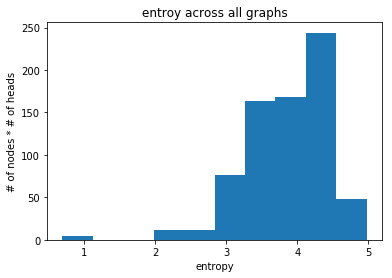

In [157]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(l1)
plt.title('entroy across all graphs')
plt.ylabel('# of nodes * # of heads')
plt.xlabel('entropy')
plt.show()

In [28]:
log_a = lambda i: i*np.log(i)
vector_log_a = np.vectorize(log_a)
num_nodes = model.g.number_of_nodes()


def node_entropy(attention, head):
    layer1 = []
    for i in range(num_nodes):
        v = vector_log_a(attention[head][i,:].todense())
        clean_v = v[~np.isnan(v)]
        layer1.append(-1*np.sum(clean_v))
    return layer1

ln = node_entropy(Attn, 1)

foo:1: RuntimeWarning: divide by zero encountered in log
foo:1: RuntimeWarning: invalid value encountered in double_scalars
/home/mastreips/anaconda3/envs/gn-exp/lib/python3.7/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


Text(0, 0.5, '# of nodes')

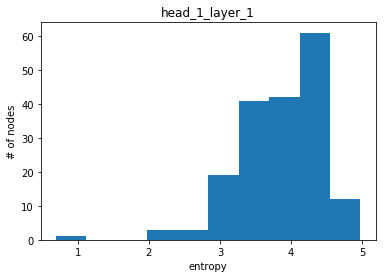

In [29]:
plt.hist(ln)
plt.title('head_1_layer_1')
plt.xlabel('entropy')
plt.ylabel('# of nodes')

In [142]:
ln = node_entropy(Attn,0)

foo:1: RuntimeWarning: divide by zero encountered in log
foo:1: RuntimeWarning: invalid value encountered in double_scalars
/home/mastreips/anaconda3/envs/gn-exp/lib/python3.7/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


Text(0, 0.5, '# of nodes')

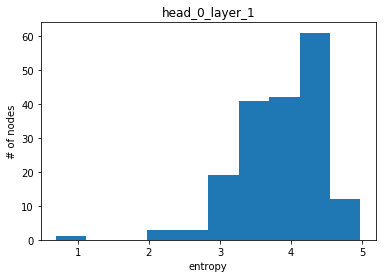

In [144]:
plt.hist(ln)
plt.title('head_0_layer_1')
plt.xlabel('entropy')
plt.ylabel('# of nodes')

In [30]:
attent= model.gat_layers[0].attn_all  
attention_det = attent.detach().numpy()

In [31]:
a4 = attention_det.reshape(attention_det.shape[0],-1).sum(axis=1)

In [32]:
print(a4)
print(a4.shape)

[0.06337787 0.1996943  0.08495032 ... 0.03880619 0.0384231  0.08862251]
(9752,)


Text(0, 0.5, '# of Edges')

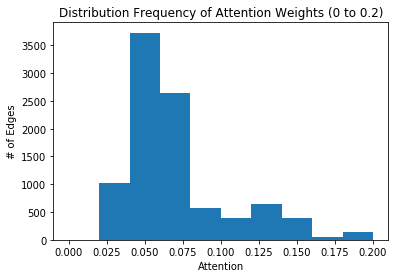

In [149]:
plt.hist(a4, range=(0,0.2))
plt.title('Distribution Frequency of Attention Weights (0 to 0.2)')
plt.xlabel('Attention')
plt.ylabel('# of Edges')

In [36]:
max(a4)

2.002082

(array([9.64e+03, 1.01e+02, 9.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 2.00e+00]),
 array([0.  , 0.21, 0.42, 0.63, 0.84, 1.05, 1.26, 1.47, 1.68, 1.89, 2.1 ],
       dtype=float32),
 <a list of 10 Patch objects>)

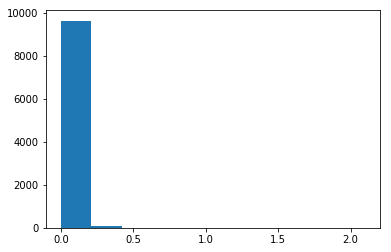

In [37]:
plt.hist(a4, range=(0,2.1))

In [40]:
anode = sum(Attn[0].todense())

for h in range(1,3):
    anode += sum(Attn[h].todense())

print(anode)

[[2.62357779 2.71658593 2.82812867 0.68777024 4.50631435 6.47795557
  2.74556838 3.15893707 2.29795487 4.81585625 2.20004492 1.4978767
  3.82973608 2.21318734 2.99258837 1.78383251 3.33083844 4.53697753
  3.34590263 3.45654571 2.83261275 2.12766453 3.67944294 1.4588517
  2.87878373 2.1976484  2.45945178 2.87373378 3.55724851 3.29050039
  3.47297962 8.8508856  2.33206288 3.34517057 1.01135603 2.1178705
  4.1340183  1.31583122 0.89651944 1.21010091 3.55467054 7.03214627
  3.83853151 3.09990928 4.22827292 4.8501281  1.76755315 1.35442739
  2.90867045 3.12216472 2.65767955 1.70519871 2.44744808 2.10598466
  3.57911002 1.12113063 3.45821402 4.61197906 3.2230368  2.02349832
  2.25738331 2.22954401 1.55428792 3.75605498 3.23550658 3.12393646
  1.22892652 3.64480408 2.37059971 2.55333461 2.90853781 7.17051426
  2.88114447 1.85484844 0.73269969 2.68606195 3.802957   5.20411328
  2.49018239 3.90491928 2.99831646 1.88632615 2.59343546 2.77155747
  2.96813778 2.84441543 6.16128483 1.83300061 4.503

In [44]:
import pandas as pd

node_attn = pd.DataFrame(list(enumerate(anode.tolist()[0])), columns=['node', 'attention'])
node_attn.sort_values('attention', ascending=False, inplace=True)

tops = node_attn.head(10)
tops


,node,attention
31,31,8.850886
71,71,7.170514
41,41,7.032146
139,139,7.019939
5,5,6.477956
86,86,6.161285
180,180,5.651488
179,179,5.509280
92,92,5.452421
104,104,5.427633


In [152]:
print(len(g.predecessors(31)))
print(len(g.predecessors(71)))
print(len(g.predecessors(41)))
print(len(g.predecessors(139)))
print(len(g.predecessors(5)))
print(len(g.predecessors(86)))
print(len(g.predecessors(180)))
print(len(g.predecessors(179)))
print(len(g.predecessors(92)))
print(len(g.predecessors(104)))

145
122
113
116
116
104
104
103
93
84


In [46]:
bottoms = node_attn.tail(10)
bottoms

,node,attention
39,39,1.210101
55,55,1.121131
128,128,1.023987
34,34,1.011356
133,133,0.962535
136,136,0.959373
122,122,0.914664
38,38,0.896519
74,74,0.732700
3,3,0.687770


In [52]:
print(min(a4))
print(np.average(a4))
print(np.median(a4))
print(max(a4))

0.027399631
0.07465136
0.06061139
2.002082


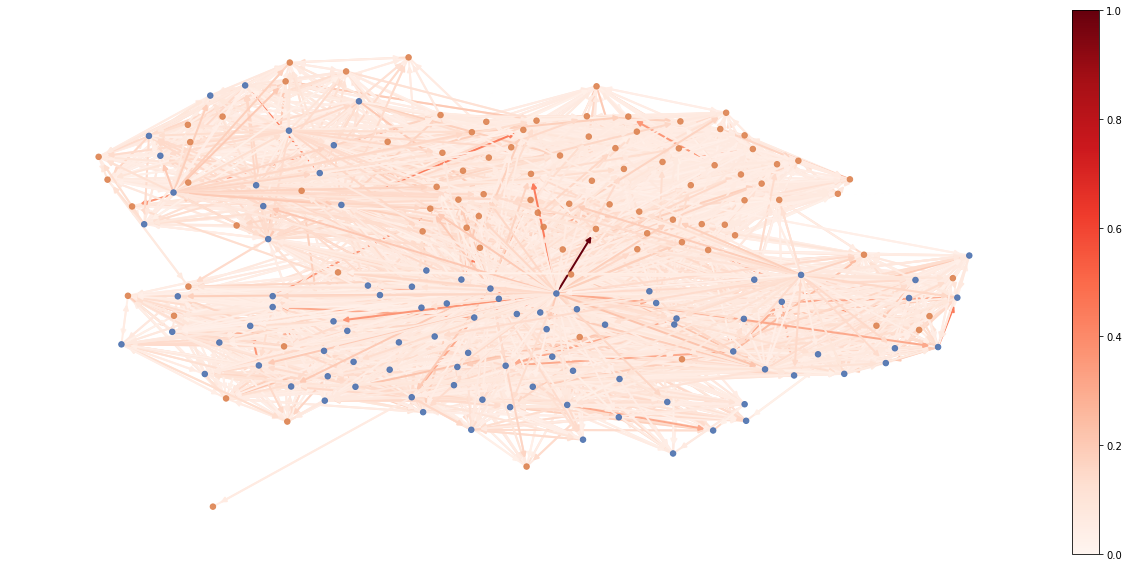

In [54]:
'''
https://discuss.dgl.ai/t/how-to-plot-the-attention-weights/206
https://networkx.github.io/documentation/stable/reference/drawing.html#layout

'''

import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

def plot(g, attention, ax, nodes_to_plot=None, nodes_labels=None,
         edges_to_plot=None, nodes_pos=None, nodes_colors=None,
         edge_colormap=plt.cm.Reds):
    """
    Visualize edge attentions by coloring edges on the graph.
    g: nx.DiGraph
        Directed networkx graph
    attention: list
        Attention values corresponding to the order of sorted(g.edges())
    ax: matplotlib.axes._subplots.AxesSubplot
        ax to be used for plot
    nodes_to_plot: list
        List of node ids specifying which nodes to plot. Default to
        be None. If None, all nodes will be plot.
    nodes_labels: list, numpy.array
        nodes_labels[i] specifies the label of the ith node, which will
        decide the node color on the plot. Default to be None. If None,
        all nodes will have the same canonical label. The nodes_labels
        should contain labels for all nodes to be plot.
    edges_to_plot: list of 2-tuples (i, j)
        List of edges represented as (source, destination). Default to
        be None. If None, all edges will be plot.
    nodes_pos: dictionary mapping int to numpy.array of size 2
        Default to be None. Specifies the layout of nodes on the plot.
    nodes_colors: list
        Specifies node color for each node class. Its length should be
        bigger than number of node classes in nodes_labels.
    edge_colormap: plt.cm
        Specifies the colormap to be used for coloring edges.
    """
    if nodes_to_plot is None:
        nodes_to_plot = sorted(g.nodes())
#         print('nodes to plot: ', nodes_to_plot)
    if edges_to_plot is None:
        assert isinstance(g, nx.DiGraph), 'Expected g to be an networkx.DiGraph' \
                                          'object, got {}.'.format(type(g))
        edges_to_plot = sorted(g.edges())
#         print('edges to plot: ', edges_to_plot)
    nx.draw_networkx_edges(g, nodes_pos, edgelist=edges_to_plot,
                           edge_color=attention, edge_cmap=edge_colormap,
                           width=2, alpha=0.5, ax=ax, edge_vmin=0,
                           edge_vmax=1.0)

    if nodes_colors is None:
        nodes_colors = sns.color_palette("deep", max(nodes_labels) + 1)
#         nodes_colors = sns.color_palette("deep", 1)

    nx.draw_networkx_nodes(g, nodes_pos, nodelist=nodes_to_plot, ax=ax, node_size=30,
                           node_color=[nodes_colors[nodes_labels[v - 1]] for v in nodes_to_plot],
                           with_labels=True, alpha=0.9)

ntx = model.g.to_networkx()   

fig, ax = plt.subplots(figsize=(20,10))
plot(ntx, attention=a4, ax=ax, nodes_pos=nx.kamada_kawai_layout(ntx), nodes_labels=labels)
ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1.0)) #changed this to 0.6 from 1.0
sm.set_array([])
plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.show()

In [47]:
def prod_out(g,node):
    in_edges = g.in_edges(node,'eid').tolist()
    out_edges = g.out_edges(node,'eid').tolist()
    e_map_in = g.find_edges(in_edges)
    e_map_out = g.find_edges(out_edges)
    e_pairs_in = list(zip(e_map_in[0].tolist(),e_map_in[1].tolist()))
    e_pairs_out = list(zip(e_map_out[0].tolist(),e_map_out[1].tolist()))
    
    attn_list_in = []
    attn_list_out = []
    for i in range(0,len(in_edges)-1):
        attn_list_in.append([in_edges[i],a4[in_edges[i]]])
    
    for i in range(0,len(out_edges)-1):
        attn_list_out.append([out_edges[i],a4[out_edges[i]]])
    
    use_nodes = g.predecessors(node).tolist()
    
    attn_list_in_pd = pd.DataFrame(attn_list_in, columns=['edgeID','attention'])
    attn_list_in_sort = attn_list_in_pd.sort_values('edgeID')

    attn_list_out_pd = pd.DataFrame(attn_list_out, columns=['edgeID','attention'])
    attn_list_out_sort = attn_list_out_pd.sort_values('edgeID')
    
    use_edges = e_pairs_out
    use_edges.remove((node,node))
    use_edges
    
    return in_edges, out_edges, e_pairs_in, e_pairs_out, use_nodes, use_edges, attn_list_in_sort, attn_list_out_sort

In [55]:
in_edges, out_edges, e_pairs_in, e_pairs_out, use_nodes, use_edges, attn_list_in_sort, attn_list_out_sort = prod_out(g,3)

In [58]:
attn_list_in_sort

,edgeID,attention
0,550,0.363520
1,1073,0.363262
2,1321,0.363448
3,1572,0.364438
4,2186,0.363873
5,2345,0.363427
6,6576,0.361875
7,6668,0.364001
8,6730,0.364810
9,6778,0.363073


In [59]:
attn_list_out_sort

,edgeID,attention
0,6566,0.043074
1,6567,0.049497
2,6568,0.047706
3,6569,0.058080
4,6570,0.063610
5,6571,0.075616
6,6572,0.081777
7,6573,0.048848
8,6574,0.045013
9,6575,0.038896


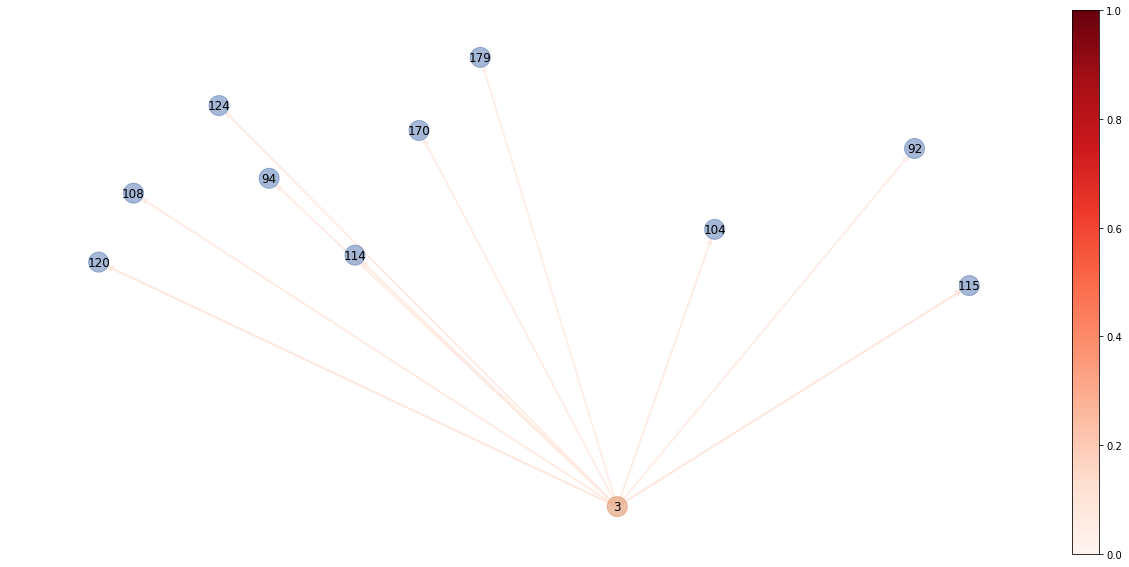

In [56]:
'''
https://discuss.dgl.ai/t/how-to-plot-the-attention-weights/206
https://networkx.github.io/documentation/stable/reference/drawing.html#layout

'''
node_id = use_nodes
use_nodes = use_nodes
use_edges = use_edges
attention = attn_list_out_sort['attention'].tolist()

import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

def plot(g, attention, ax, nodes_to_plot=None, nodes_labels=None,
         edges_to_plot=None, nodes_pos=None, nodes_colors=None,
         edge_colormap=plt.cm.Reds):
    """
    Visualize edge attentions by coloring edges on the graph.
    g: nx.DiGraph
        Directed networkx graph
    attention: list
        Attention values corresponding to the order of sorted(g.edges())
    ax: matplotlib.axes._subplots.AxesSubplot
        ax to be used for plot
    nodes_to_plot: list
        List of node ids specifying which nodes to plot. Default to
        be None. If None, all nodes will be plot.
    nodes_labels: list, numpy.array
        nodes_labels[i] specifies the label of the ith node, which will
        decide the node color on the plot. Default to be None. If None,
        all nodes will have the same canonical label. The nodes_labels
        should contain labels for all nodes to be plot.
    edges_to_plot: list of 2-tuples (i, j)
        List of edges represented as (source, destination). Default to
        be None. If None, all edges will be plot.
    nodes_pos: dictionary mapping int to numpy.array of size 2
        Default to be None. Specifies the layout of nodes on the plot.
    nodes_colors: list
        Specifies node color for each node class. Its length should be
        bigger than number of node classes in nodes_labels.
    edge_colormap: plt.cm
        Specifies the colormap to be used for coloring edges.
    """
    if nodes_to_plot is None:
        nodes_to_plot = sorted(g.nodes())
#         print('nodes to plot: ', nodes_to_plot)
    if edges_to_plot is None:
        assert isinstance(g, nx.DiGraph), 'Expected g to be an networkx.DiGraph' \
                                          'object, got {}.'.format(type(g))
        edges_to_plot = sorted(g.edges())
#         print('edges to plot: ', edges_to_plot)
    nx.draw_networkx_edges(g, nodes_pos, edgelist=edges_to_plot,
                           edge_color=attention, edge_cmap=edge_colormap,
                           width=2, alpha=0.2, ax=ax, edge_vmin=0.0,
                           edge_vmax=1.0)

    if nodes_colors is None:
        nodes_colors = sns.color_palette("deep", max(nodes_labels) + 1)
#         nodes_colors = sns.color_palette("deep", 1)

    nx.draw_networkx_nodes(g, nodes_pos, nodelist=nodes_to_plot, ax=ax, node_size=400,
                           node_color=[nodes_colors[nodes_labels[v - 1]] for v in nodes_to_plot], alpha=0.5)
    
    nx.draw_networkx_labels(g, nodes_pos, labels=dict([(n, n) for n in use_nodes]), ax=ax)

ntx = model.g.to_networkx()   

fig, ax = plt.subplots(figsize=(20,10))
plot(ntx, attention=attention, nodes_to_plot=use_nodes, edges_to_plot=use_edges, ax=ax, nodes_pos=nx.kamada_kawai_layout(ntx), nodes_labels=labels) #changed attention=st_list to a4
# plot(ntx, attention=attention, nodes_to_plot=use_nodes, edges_to_plot=use_edges, ax=ax, nodes_pos=nx.spring_layout(ntx), nodes_labels=labels) #changed attention=st_list to a4

ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0.0, vmax=1.0)) #changed this to 0.6 from 1.0
sm.set_array([])
plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.show()

In [62]:
all_edges = g.all_edges('eid').tolist()

In [63]:
attn_list_all = []
for i in range(0,len(all_edges)-1):
    attn_list_all.append([all_edges[i],a4[all_edges[i]]])

In [65]:
attn_all_list_pd = pd.DataFrame(attn_list_all, columns=['edgeID','attention'])
atten_df_sorted = attn_all_list_pd.sort_values('attention', ascending=False)
atten_df_sorted.head(10)

,edgeID,attention
2047,2047,2.002082
9632,9632,1.997918
6044,6044,0.446396
399,399,0.444889
2896,2896,0.444672
9608,9608,0.444610
8835,8835,0.444288
8238,8238,0.443917
9171,9171,0.443798
8887,8887,0.443773


In [66]:
g.find_edges([2047])

(tensor([162]), tensor([62]))

In [67]:
g.find_edges([9632])

(tensor([62]), tensor([62]))

In [68]:
g.predecessors(62)

tensor([ 62, 162])

In [153]:
g.find_edges([6044])

(tensor([86]), tensor([38]))

In [154]:
g.find_edges([399])

(tensor([71]), tensor([38]))

In [155]:
g.find_edges([2896,9608,8835,8238,9171,8887])

(tensor([  9,  38,  52, 152, 149,  89]), tensor([38, 38, 38, 38, 38, 38]))

In [156]:
g.find_edges([9608])

(tensor([38]), tensor([38]))

In [69]:
in_edges, out_edges, e_pairs_in, e_pairs_out, use_nodes, use_edges, attn_list_in_sort, attn_list_out_sort = prod_out(g,62)

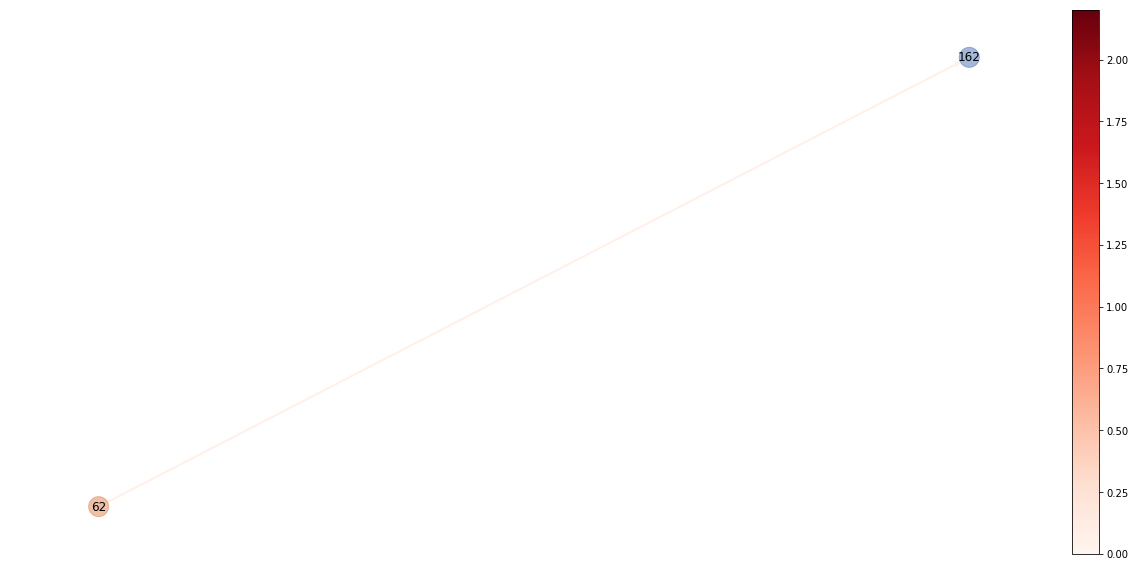

In [71]:
'''
https://discuss.dgl.ai/t/how-to-plot-the-attention-weights/206
https://networkx.github.io/documentation/stable/reference/drawing.html#layout

'''
node_id = use_nodes
use_nodes = use_nodes
use_edges = use_edges
attention = attn_list_out_sort['attention'].tolist()

import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

def plot(g, attention, ax, nodes_to_plot=None, nodes_labels=None,
         edges_to_plot=None, nodes_pos=None, nodes_colors=None,
         edge_colormap=plt.cm.Reds):
    """
    Visualize edge attentions by coloring edges on the graph.
    g: nx.DiGraph
        Directed networkx graph
    attention: list
        Attention values corresponding to the order of sorted(g.edges())
    ax: matplotlib.axes._subplots.AxesSubplot
        ax to be used for plot
    nodes_to_plot: list
        List of node ids specifying which nodes to plot. Default to
        be None. If None, all nodes will be plot.
    nodes_labels: list, numpy.array
        nodes_labels[i] specifies the label of the ith node, which will
        decide the node color on the plot. Default to be None. If None,
        all nodes will have the same canonical label. The nodes_labels
        should contain labels for all nodes to be plot.
    edges_to_plot: list of 2-tuples (i, j)
        List of edges represented as (source, destination). Default to
        be None. If None, all edges will be plot.
    nodes_pos: dictionary mapping int to numpy.array of size 2
        Default to be None. Specifies the layout of nodes on the plot.
    nodes_colors: list
        Specifies node color for each node class. Its length should be
        bigger than number of node classes in nodes_labels.
    edge_colormap: plt.cm
        Specifies the colormap to be used for coloring edges.
    """
    if nodes_to_plot is None:
        nodes_to_plot = sorted(g.nodes())
#         print('nodes to plot: ', nodes_to_plot)
    if edges_to_plot is None:
        assert isinstance(g, nx.DiGraph), 'Expected g to be an networkx.DiGraph' \
                                          'object, got {}.'.format(type(g))
        edges_to_plot = sorted(g.edges())
#         print('edges to plot: ', edges_to_plot)
    nx.draw_networkx_edges(g, nodes_pos, edgelist=edges_to_plot,
                           edge_color=attention, edge_cmap=edge_colormap,
                           width=2, alpha=0.2, ax=ax, edge_vmin=0.0,
                           edge_vmax=2.2)

    if nodes_colors is None:
        nodes_colors = sns.color_palette("deep", max(nodes_labels) + 1)
#         nodes_colors = sns.color_palette("deep", 1)

    nx.draw_networkx_nodes(g, nodes_pos, nodelist=nodes_to_plot, ax=ax, node_size=400,
                           node_color=[nodes_colors[nodes_labels[v - 1]] for v in nodes_to_plot], alpha=0.5)
    
    nx.draw_networkx_labels(g, nodes_pos, labels=dict([(n, n) for n in use_nodes]), ax=ax)

ntx = model.g.to_networkx()   

fig, ax = plt.subplots(figsize=(20,10))
plot(ntx, attention=attention, nodes_to_plot=use_nodes, edges_to_plot=use_edges, ax=ax, nodes_pos=nx.kamada_kawai_layout(ntx), nodes_labels=labels) #changed attention=st_list to a4
# plot(ntx, attention=attention, nodes_to_plot=use_nodes, edges_to_plot=use_edges, ax=ax, nodes_pos=nx.spring_layout(ntx), nodes_labels=labels) #changed attention=st_list to a4

ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0.0, vmax=2.2)) #changed this to 0.6 from 1.0
sm.set_array([])
plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.show()

In [72]:
attn_list_out_sort['attention'].tolist()

[0.07524469494819641]

In [73]:
attn_list_in_sort['attention'].tolist()

[2.002082109451294]

In [77]:
g.find_edges([8887])

(tensor([89]), tensor([38]))

In [78]:
g.predecessors(89)

tensor([  9,  38,  41,  52,  59,  75,  78,  86,  89,  91, 102, 113, 134, 145,
        148, 149, 152, 154, 156, 166])

In [79]:
g.predecessors(38)

tensor([  9,  38,  52,  71,  86,  89, 149, 152, 154])

In [80]:
in_edges, out_edges, e_pairs_in, e_pairs_out, use_nodes, use_edges, attn_list_in_sort, attn_list_out_sort = prod_out(g,89)

In [81]:
attn_list_in_sort

,edgeID,attention
0,2935,0.200190
1,4179,0.199711
2,6082,0.200993
3,6329,0.200377
4,6966,0.199703
5,6994,0.200214
6,7018,0.200184
7,7200,0.198930
8,7231,0.200220
9,7263,0.200157


In [82]:
attn_list_out_sort

,edgeID,attention
0,8886,0.047471
1,8887,0.443773
2,8888,0.035306
3,8889,0.153570
4,8890,0.181625
5,8891,0.137711
6,8892,0.133053
7,8893,0.038361
8,8894,0.159774
9,8895,0.159731


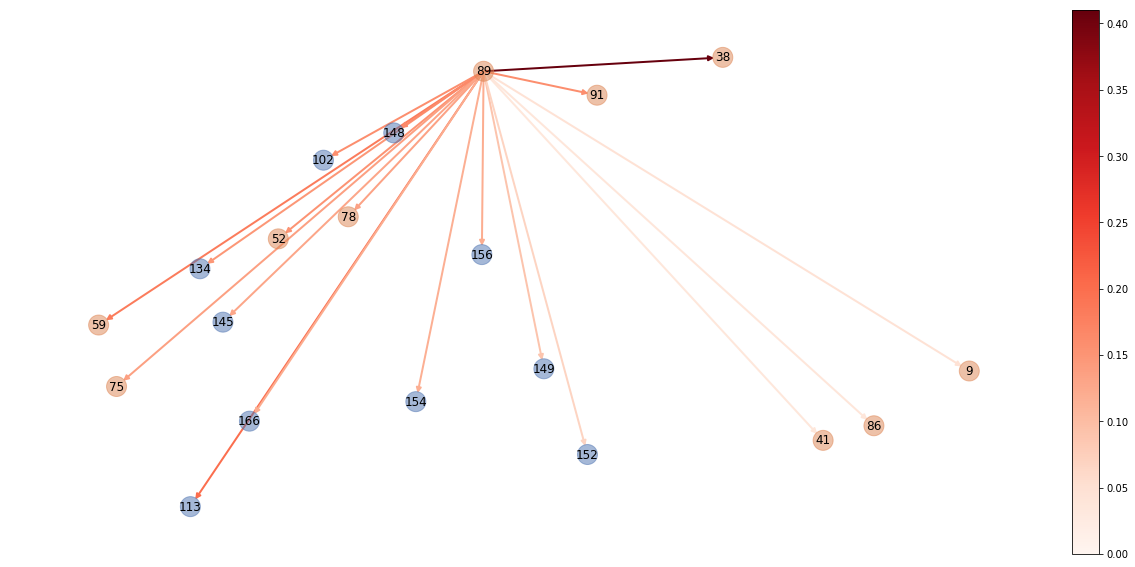

In [83]:
'''
https://discuss.dgl.ai/t/how-to-plot-the-attention-weights/206
https://networkx.github.io/documentation/stable/reference/drawing.html#layout

'''
node_id = use_nodes
use_nodes = use_nodes
use_edges = use_edges
attention = attn_list_out_sort['attention'].tolist()

import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

def plot(g, attention, ax, nodes_to_plot=None, nodes_labels=None,
         edges_to_plot=None, nodes_pos=None, nodes_colors=None,
         edge_colormap=plt.cm.Reds):
    """
    Visualize edge attentions by coloring edges on the graph.
    g: nx.DiGraph
        Directed networkx graph
    attention: list
        Attention values corresponding to the order of sorted(g.edges())
    ax: matplotlib.axes._subplots.AxesSubplot
        ax to be used for plot
    nodes_to_plot: list
        List of node ids specifying which nodes to plot. Default to
        be None. If None, all nodes will be plot.
    nodes_labels: list, numpy.array
        nodes_labels[i] specifies the label of the ith node, which will
        decide the node color on the plot. Default to be None. If None,
        all nodes will have the same canonical label. The nodes_labels
        should contain labels for all nodes to be plot.
    edges_to_plot: list of 2-tuples (i, j)
        List of edges represented as (source, destination). Default to
        be None. If None, all edges will be plot.
    nodes_pos: dictionary mapping int to numpy.array of size 2
        Default to be None. Specifies the layout of nodes on the plot.
    nodes_colors: list
        Specifies node color for each node class. Its length should be
        bigger than number of node classes in nodes_labels.
    edge_colormap: plt.cm
        Specifies the colormap to be used for coloring edges.
    """
    if nodes_to_plot is None:
        nodes_to_plot = sorted(g.nodes())
#         print('nodes to plot: ', nodes_to_plot)
    if edges_to_plot is None:
        assert isinstance(g, nx.DiGraph), 'Expected g to be an networkx.DiGraph' \
                                          'object, got {}.'.format(type(g))
        edges_to_plot = sorted(g.edges())
#         print('edges to plot: ', edges_to_plot)
    nx.draw_networkx_edges(g, nodes_pos, edgelist=edges_to_plot,
                           edge_color=attention, edge_cmap=edge_colormap,
                           width=2, alpha=0.2, ax=ax, edge_vmin=0.0,
                           edge_vmax=0.41)

    if nodes_colors is None:
        nodes_colors = sns.color_palette("deep", max(nodes_labels) + 1)
#         nodes_colors = sns.color_palette("deep", 1)

    nx.draw_networkx_nodes(g, nodes_pos, nodelist=nodes_to_plot, ax=ax, node_size=400,
                           node_color=[nodes_colors[nodes_labels[v - 1]] for v in nodes_to_plot], alpha=0.5)
    
    nx.draw_networkx_labels(g, nodes_pos, labels=dict([(n, n) for n in use_nodes]), ax=ax)

ntx = model.g.to_networkx()   

fig, ax = plt.subplots(figsize=(20,10))
plot(ntx, attention=attention, nodes_to_plot=use_nodes, edges_to_plot=use_edges, ax=ax, nodes_pos=nx.kamada_kawai_layout(ntx), nodes_labels=labels) #changed attention=st_list to a4
# plot(ntx, attention=attention, nodes_to_plot=use_nodes, edges_to_plot=use_edges, ax=ax, nodes_pos=nx.spring_layout(ntx), nodes_labels=labels) #changed attention=st_list to a4

ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0.0, vmax=0.41)) #changed this to 0.6 from 1.0
sm.set_array([])
plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.show()

In [88]:
print(all_data_df.iloc[89,0])



There’s a lot to be discussed about last night’s debate between Hillary Clinton and Donald Trump. One thing that has baffled many is how Hillary seemed so ready with answers and detailed facts and, almost as bizarrely, she didn’t cough or reach for water once.

Well, this twitter user might have an answer. Do you see it?

I think we all know why #TrumpWon pic.twitter.com/nwZRxvkX81 — USA For Trump 2016 (@USAforTrump2016) September 27, 2016

This wouldn’t be the first time Hillary had to use a device for help. What do you think? Is just a trick of light and shadows? A zipper? Or was Hillary actually hiding a “Cough prevention machine” in her pantsuit?

Will you support Donald Trump, Hillary Clinton or another candidate? Share your thoughts!

And LIKE this page for the latest TRUMP news. Interested in stopping Hillary? LIKE this page


In [89]:
print(all_data_df.iloc[38,0])

Well THAT’S Weird. If the Birther movement is racist… does that mean that the person who wrote this had it in for Obama?

What if that person is … Obama?

Breitbart put this out, taken from the AP, entitled ““Kenyan-born Obama all set for US Senate” That was June 2004.

Kenyan-born US Senate hopeful, Barrack Obama, appeared set to take over the Illinois Senate seat after his main rival, Jack Ryan, dropped out of the race on Friday night amid a furor over lurid sex club allegations. The allegations that horrified fellow Republicans and caused his once-promising candidacy to implode in four short days have given Obama a clear lead as Republicans struggled to fetch an alternative. As far as we know, Barack Obama never refuted this article.

It’s still out there on the internet. Here’s a screen capture:

Here’s the bottom half of the same article with AP attribution.

And the link to the original.

That’s not actually as weird as the one all the way back in 1991.

That was Obama’s publicis

In [91]:
g.find_edges([399])

(tensor([71]), tensor([38]))

In [92]:
g.predecessors(71)

tensor([  0,   1,   2,   4,   5,   6,   8,   9,  11,  12,  14,  15,  16,  17,
         18,  19,  20,  21,  22,  24,  26,  28,  29,  30,  31,  33,  36,  38,
         39,  40,  41,  42,  43,  44,  45,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  58,  59,  60,  61,  63,  64,  65,  67,  68,  69,  70,
         71,  72,  75,  76,  77,  78,  79,  80,  82,  83,  84,  85,  86,  87,
         88,  90,  92,  94,  96,  97,  99, 100, 101, 103, 105, 107, 109, 110,
        112, 113, 114, 117, 118, 119, 120, 121, 123, 124, 125, 129, 134, 135,
        137, 138, 139, 140, 141, 143, 145, 147, 149, 150, 151, 152, 153, 154,
        156, 159, 162, 166, 167, 168, 170, 174, 179, 180])

In [97]:
in_edges, out_edges, e_pairs_in, e_pairs_out, use_nodes, use_edges, attn_list_in_sort, attn_list_out_sort = prod_out(g,71)

In [ ]:
attn_list_in_sort

In [109]:
print(min(attn_list_out_sort['attention'].tolist()))
print(np.average(attn_list_out_sort['attention'].tolist()))
print(np.median(attn_list_out_sort['attention'].tolist()))
print(max(attn_list_out_sort['attention'].tolist()))

0.027587151154875755
0.07875593682397003
0.06351232528686523
0.4448893070220947


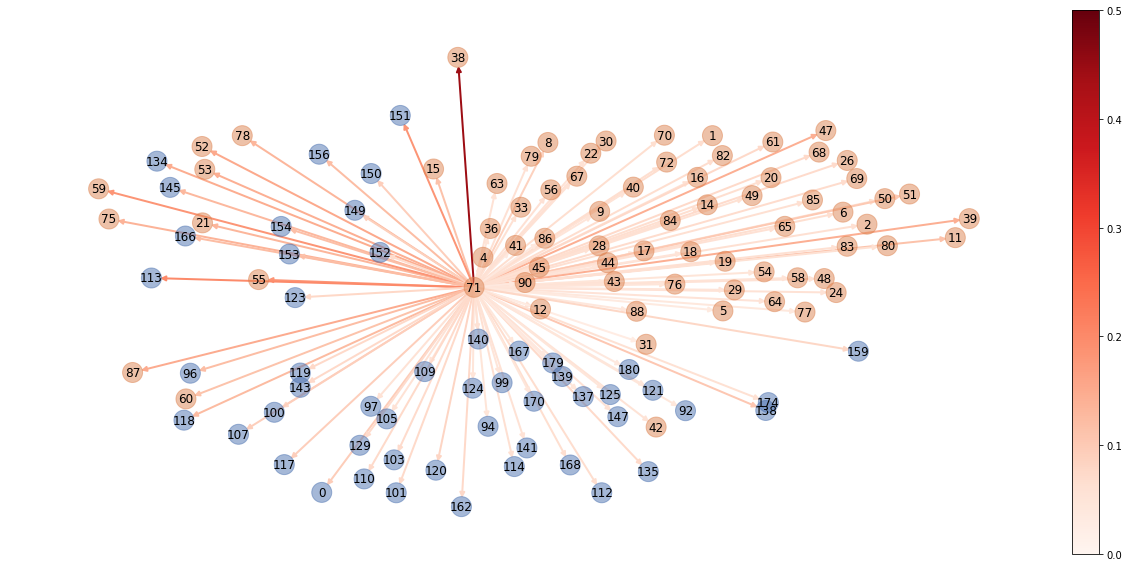

In [110]:
'''
https://discuss.dgl.ai/t/how-to-plot-the-attention-weights/206
https://networkx.github.io/documentation/stable/reference/drawing.html#layout

'''
node_id = use_nodes
use_nodes = use_nodes
use_edges = use_edges
attention = attn_list_out_sort['attention'].tolist()

import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

def plot(g, attention, ax, nodes_to_plot=None, nodes_labels=None,
         edges_to_plot=None, nodes_pos=None, nodes_colors=None,
         edge_colormap=plt.cm.Reds):
    """
    Visualize edge attentions by coloring edges on the graph.
    g: nx.DiGraph
        Directed networkx graph
    attention: list
        Attention values corresponding to the order of sorted(g.edges())
    ax: matplotlib.axes._subplots.AxesSubplot
        ax to be used for plot
    nodes_to_plot: list
        List of node ids specifying which nodes to plot. Default to
        be None. If None, all nodes will be plot.
    nodes_labels: list, numpy.array
        nodes_labels[i] specifies the label of the ith node, which will
        decide the node color on the plot. Default to be None. If None,
        all nodes will have the same canonical label. The nodes_labels
        should contain labels for all nodes to be plot.
    edges_to_plot: list of 2-tuples (i, j)
        List of edges represented as (source, destination). Default to
        be None. If None, all edges will be plot.
    nodes_pos: dictionary mapping int to numpy.array of size 2
        Default to be None. Specifies the layout of nodes on the plot.
    nodes_colors: list
        Specifies node color for each node class. Its length should be
        bigger than number of node classes in nodes_labels.
    edge_colormap: plt.cm
        Specifies the colormap to be used for coloring edges.
    """
    if nodes_to_plot is None:
        nodes_to_plot = sorted(g.nodes())
#         print('nodes to plot: ', nodes_to_plot)
    if edges_to_plot is None:
        assert isinstance(g, nx.DiGraph), 'Expected g to be an networkx.DiGraph' \
                                          'object, got {}.'.format(type(g))
        edges_to_plot = sorted(g.edges())
#         print('edges to plot: ', edges_to_plot)
    nx.draw_networkx_edges(g, nodes_pos, edgelist=edges_to_plot,
                           edge_color=attention, edge_cmap=edge_colormap,
                           width=2, alpha=0.2, ax=ax, edge_vmin=0.0,
                           edge_vmax=0.5)

    if nodes_colors is None:
        nodes_colors = sns.color_palette("deep", max(nodes_labels) + 1)
#         nodes_colors = sns.color_palette("deep", 1)

    nx.draw_networkx_nodes(g, nodes_pos, nodelist=nodes_to_plot, ax=ax, node_size=400,
                           node_color=[nodes_colors[nodes_labels[v - 1]] for v in nodes_to_plot], alpha=0.5)
    
    nx.draw_networkx_labels(g, nodes_pos, labels=dict([(n, n) for n in use_nodes]), ax=ax)

ntx = model.g.to_networkx()   

fig, ax = plt.subplots(figsize=(20,10))
plot(ntx, attention=attention, nodes_to_plot=use_nodes, edges_to_plot=use_edges, ax=ax, nodes_pos=nx.kamada_kawai_layout(ntx), nodes_labels=labels) #changed attention=st_list to a4
# plot(ntx, attention=attention, nodes_to_plot=use_nodes, edges_to_plot=use_edges, ax=ax, nodes_pos=nx.spring_layout(ntx), nodes_labels=labels) #changed attention=st_list to a4

ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0.0, vmax=0.5)) #changed this to 0.6 from 1.0
sm.set_array([])
plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.show()

In [112]:
print(all_data_df.iloc[71,0])

New Clinton Foundation SCANDAL Just Broke – This Is What Hillary ACTUALLY Thinks About Black People…

This is just criminal and it is no surprise it involves the Clinton Health Access Initiative. Anything with ‘Clinton’ in it has to be corrupt, but this resulted in the deaths of many, many Africans. They distributed “watered-down” HIV/AIDs drugs to patients, virtually sentencing them to death. An Indian drug manufacturer called Ranbaxy was behind this… the question is, did the Clintons know about it. I’m betting that they did.

Ranbaxy was eventually found guilty in 2013 on seven counts with intent to defraud and the introduction of adulterated drugs into interstate commerce. The DOJ also levied a $500 million fine and forfeiture against the company. So, one wonders why the Clintons were not also looked into and questioned on all of this.

“This is the largest false claims case ever prosecuted in the District of Maryland, and the nation’s largest financial penalty paid by a generic pha

In [87]:
all_data_df

,text,label
0,5.2k SHARES Facebook Twitter\n\nPresident Obam...,1
1,2.8k SHARES Facebook Twitter\n\nA border wall ...,1
2,Hillary Clinton’s health is the top issue in t...,1
3,EXPOSED: Soros Funding Fake Veterans’ PAC To T...,1
4,Hillary’s TOP Donor Country Just Auctioned Off...,1
5,196 SHARES Facebook Twitter\n\nFor a little ov...,1
6,When Donald Trump said that he wanted to ban M...,1
7,What would possess anyone to take control of t...,1
8,BREAKING: Steps to FORCE FBI Director Comey to...,1
9,We’re shocked — SHOCKED — to learn that CNN’s ...,1
